# Хакатон "Лента х Практикум"

## Описание проекта

**Краткое описание:**
Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного
производства. Гранулярность ТК-SKU-День.

**Термины:**
- ТК - Торговый комплекс
- SKU - Товар
- СП - собственное производство

**Задача:**
Построить модель прогноза спроса на основе мастер данных и данных продаж с учетом разных
признаков.

**Цель:**
Сгенерировать различные признаки и придумать интерпретируемую, описывающую правильные
зависимости (повышение цены вызывает логичное падение спроса), модель прогноза спроса.
Дальше необходимо сделать подневной прогноз спроса на тестовом периоде для каждого товара
и магазина, и команда Ленты оценит его качество в сравнении с свершившимся фактом.
Метрикой качества будет выступать WAPE, посчитанный на уровне товар, магазин, день. Если
есть пропущенные значения и по каким-то товарам не предоставлен прогноз, прогноз считается
равным нулю.

**Требования к результату:**
1. Файл в зафиксированном формате с результатом прогноза спроса(sales_submission.csv).
2. Воспроизводимый код на Python
3. Описание решения:
    + Описание модели прогноза спроса, которую вы зафитили
        + Признаки
        + интерпретация (`shapley values`),
        + кросс-валидация
        + алгоритмы
    + Описание вашего алгоритма оптимизации:
        + методология расчетов
        + скорость оптимизации

**Критерии оценки:**
У вас есть тестовый датасет за более поздние периоды в рамках групп товаров собственного
производства. Ваш алгоритм должен показать высокую точность прогнозирования спроса с
использованием признаков, которые вы сочтёте нужными.
Критерии оценки – WAPE + алгоритм прогноза спроса является понятным, эффективным и
масштабируемым.

## Знакомство с данными

Раздел начинается с импорта библиотек, объявления констант и новых функций. За этим следует чтение датасетов с их последующим знакомством.

In [1]:
# импорт осн. библиотек
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# импорт спец. модулей
from phik import phik_matrix 
from phik.report import plot_correlation_matrix
from IPython.display import Markdown

# игнорирование предупреждений
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Константы
FIGSIZE = (15, 6)
RANDOM_STATE = 42

DATA_PATH_1 = "C:\\Users\\Natalia\\Desktop\\Lenta_YM\\sp_sales_task\\"
DATA_PATH_2 = 'datasets/'

In [3]:
# функция демонстрации общей информации датасета
def display_dataset_info(dataset, name):
    display(Markdown(f"**~~~~~~~ {name} ~~~~~~~**"))
    display(Markdown("**Общая информация о датасете**")) 
    display(dataset.head())
    display(dataset.info())
    display(Markdown('**Количество пропусков в датасете**'))
    print(dataset.isna().sum())
    display(Markdown('**Дубликаты**'))
    print('Количество явных дубликатов:', dataset.duplicated().sum())
    print('-'*50)
    display(Markdown('**Гистограммы числовых значений**'))
    dataset.hist(figsize=(9, 9), bins=50, color='#003C96', edgecolor='blue', linewidth=1.2, alpha=0.7)

In [4]:
# функция построения кастомного графика Boxplot
def plot_box_strip(dataset, columns, color):
    for i in columns:
        plt.subplots(figsize=(15, 2))
        ax = sns.boxplot(data=dataset[i], color=color, orient="h")
        ax = sns.stripplot(data=dataset[i], orient="h", color="orangered", jitter=0.2, size=2.5)
        plt.title(i, loc="left")
        plt.show()

In [5]:
# функция построения кастомного графика Hist
def plot_hist(dataset, columns, color, bins):
    for column in columns:
        dataset[column].hist(bins=bins, figsize=(10, 10), color=color, edgecolor='blue', linewidth=1.2, alpha=0.7)
        plt.title(f'Histogram for {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

In [6]:
# функция построения матрицы корреляции Фика
def phik_matrix_plot(df, int_cols):
    phik_overview = df.phik_matrix(interval_cols=int_cols)
    plot_correlation_matrix(phik_overview.values,
                            x_labels=phik_overview.columns,
                            y_labels=phik_overview.index,
                            title=r'Корреляция Крамера $\phi_K$',
                            fontsize_factor=1.5,
                            color_map='PuBuGn',
                            figsize=(15, 15),
                            vmin=0,
                            vmax=1)
    plt.tight_layout()

Далее _чтение датасетов_. Исходный набор данных состоит из четырёх датасетов:
1. `pr_df.csv` - данные по товарной иерархии,
2. `pr_st.csv` - данные по магазинам,
3. `sales_df_train.csv` - данные по продажам за скользящий год для обучения,
4. `sales_submission.csv` - пример файла с результатом работы модели прогноза спроса.

In [7]:
# чтение датасетов
if os.path.exists(f"{DATA_PATH_1}sales_df_train.csv"):
    sales_df = pd.read_csv(f"{DATA_PATH_1}sales_df_train.csv", parse_dates=['date'])
    goods_df = pd.read_csv(f"{DATA_PATH_1}pr_df.csv")
    markets_df = pd.read_csv(f"{DATA_PATH_1}st_df.csv")
    sales_submission = pd.read_csv(f"{DATA_PATH_1}sales_submission.csv", parse_dates=['date'])
    holidays = pd.read_csv(f"{DATA_PATH_1}holidays_covid_calendar.csv", parse_dates=['date'], date_format='%d.%m.%Y')

elif os.path.exists(f"{DATA_PATH_2}sales_df_train.csv"):
    sales_df = pd.read_csv(f"{DATA_PATH_2}sales_df_train.csv", parse_dates=['date'])
    goods_df = pd.read_csv(f"{DATA_PATH_2}pr_df.csv")
    markets_df = pd.read_csv(f"{DATA_PATH_2}st_df.csv")
    sales_submission = pd.read_csv(f"{DATA_PATH_2}sales_submission.csv", parse_dates=['date'])
    holidays = pd.read_csv(f"{DATA_PATH_2}holidays_covid_calendar.csv", parse_dates=['date'], date_format='%d.%m.%Y')

else:
    print("Файлы не найдены. Проверьте путь к файлам.")

### Товарная иерархия

Это сводная таблица, несущая исключительно информационный характер. Описание колонок по значению, от большего к меньшему: pr_group_id -> pr_cat_id -> pr_subcat_id -> pr_sku_id.
- `pr_group_id` – захэшированная группа товара;
- `pr_cat_id` – захэшированная категория товара;
- `pr_subcat_id` – захэшированная подкатегория товара;
- `pr_sku_id` – захэшированное id товара;
- `pr_uom_id` - маркер, обозначающий продаётся товар на вес или в ШТ.

**~~~~~~~ Товарная иерархия ~~~~~~~**

**Общая информация о датасете**

,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,fd064933250b0bfe4f926b867b0a5ec8,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
1,71c9661741caf40a92a32d1cc8206c04,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
2,00b72c2f01a1512cbb1d3f33319bac93,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17
3,9bc40cd2fe4f188f402bb41548c5e15c,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
4,3a74a370c8eb032acb11ad9119242b8f,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


None

**Количество пропусков в датасете**

pr_sku_id       0
pr_group_id     0
pr_cat_id       0
pr_subcat_id    0
pr_uom_id       0
dtype: int64


**Дубликаты**

Количество явных дубликатов: 0
--------------------------------------------------


**Гистограммы числовых значений**

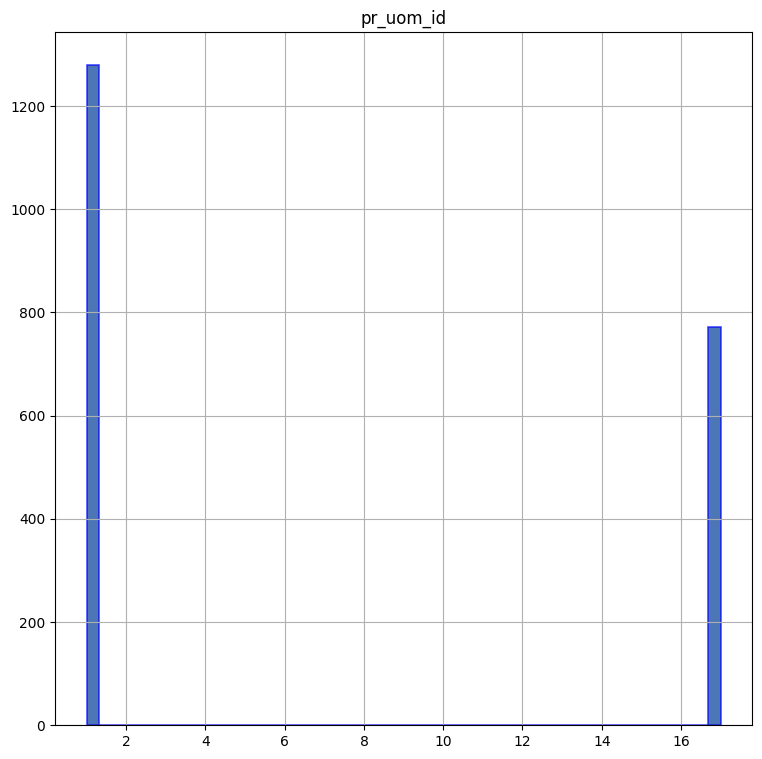

In [8]:
display_dataset_info(goods_df, 'Товарная иерархия')

In [9]:
# подсчёт кол-ва уникальных значений
display(Markdown("**Подсчёт кол-ва уникальных значений в таблице товарной иерархии**"))
print('Кол-во групп:', len(goods_df['pr_group_id'].unique()))
print('Кол-во категорий:', len(goods_df['pr_cat_id'].unique()))
print('Кол-во подкатегорий:', len(goods_df['pr_subcat_id'].unique()))
print('Кол-во уникальных товаров:', len(goods_df['pr_sku_id'].unique()))
print('Значения меток фасовки товаров (на вес / поштучно):', goods_df['pr_uom_id'].unique())

**Подсчёт кол-ва уникальных значений в таблице товарной иерархии**

Кол-во групп: 9
Кол-во категорий: 43
Кол-во подкатегорий: 170
Кол-во уникальных товаров: 2050
Значения меток фасовки товаров (на вес / поштучно): [17  1]


**ВЫВОД**:  
- Пропуски отсутствуют. 
- Столбец `pr_sku_id` содержит уникальные значения и может выполнять роль индекса (первичного ключа). 
- Тип данных соответствует, за исключения столбца `pr_uom_id`. Возможно, для него подойдёт bool-ый тип данных, поскольку значения бинарны.

### Данные по магазинам

Это сводная таблица, несущая исключительно информационный характер. Описание столбцов:
- `st_id` – захэшированное id магазина;
- `st_city_id` – захэшированное id города;
- `st_division_code id` – захэшированное id дивизиона;
- `st_type_format_id` – id формата магазина;
- `st_type_loc_id` – id тип локации/окружения магазина;
- `st_type_size_id` – id типа размера магазина;
- `st_is_active` – флаг активного магазина на данный момент.

**~~~~~~~ Данные по магазинам ~~~~~~~**

**Общая информация о датасете**

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
1,bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1
2,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
3,1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 804.0+ bytes


None

**Количество пропусков в датасете**

st_id                0
st_city_id           0
st_division_code     0
st_type_format_id    0
st_type_loc_id       0
st_type_size_id      0
st_is_active         0
dtype: int64


**Дубликаты**

Количество явных дубликатов: 0
--------------------------------------------------


**Гистограммы числовых значений**

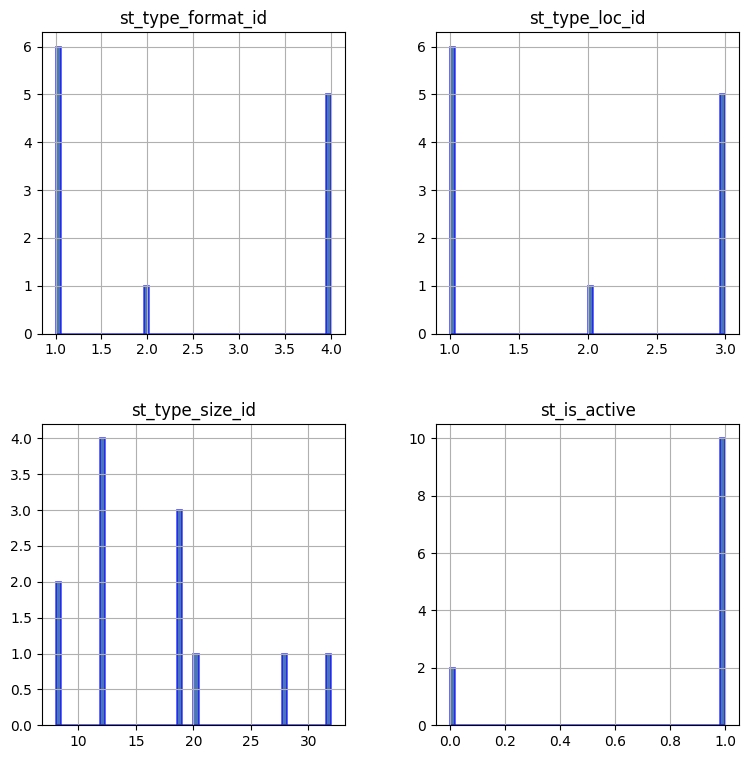

In [10]:
display_dataset_info(markets_df, 'Данные по магазинам')

In [11]:
# уникальные значения
display(Markdown("**Подсчёт кол-ва уникальных значений в таблице магазинов**"))
print('Кол-во магазинов:', len(markets_df['st_id'].unique()))
print('Кол-во городов:', len(markets_df['st_city_id'].unique()))
print('Кол-во дивизионов:', len(markets_df['st_division_code'].unique()))
print('Форматы магазинов:', markets_df['st_type_format_id'].unique())
print('Типы локации/окружения:', markets_df['st_type_loc_id'].unique())
print('Типы размеров магазина:', markets_df['st_type_size_id'].unique())

**Подсчёт кол-ва уникальных значений в таблице магазинов**

Кол-во магазинов: 12
Кол-во городов: 7
Кол-во дивизионов: 6
Форматы магазинов: [4 1 2]
Типы локации/окружения: [3 1 2]
Типы размеров магазина: [19 12 28  8 20 32]


In [12]:
display(Markdown("**Неактивные магазины**")) 
display( markets_df[markets_df['st_is_active'] == 0])
not_active_st_id =  markets_df.loc[markets_df['st_is_active'] == 0, 'st_id'].values

**Неактивные магазины**

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
10,62f91ce9b820a491ee78c108636db089,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,32,0


**ВЫВОД**:  
- Всего 12 магазинов в 7 городах (6 дивизионах), которые расположены на 3х типах локаций. 
- Среди них встречаются 3 формата магазинов: 1, 2 и 4 (внезапно), а так же 6 типоа размера магазинов. 
- Все эти признаки **категориальные** и подлежат кодированию, возможно.
- Два магазина, не действующих на данный момент, вероятно стоит удалить, поскольку прогнозирование для него не целесообразно.

### Данные по продажам

Данные собраны за скользящий год. Предназначены для обучения. В датасете не содержатся данных о списании невостребованных/неликвидных остатков товаров. Описание столбцов:
- `st_id` – захэшированное id магазина;
- `pr_sku_id` – захэшированное id товара;
- `date` – дата;
- `pr_sales_type_id` – флаг наличия промо;
- `pr_sales_in_units` – число проданных товаров всего (с промо и без);
- `pr_promo_sales_in_units` – число проданных товаров с признаком промо;
- `pr_sales_in_rub` – продажи товаров всего (с промо и без);
- `pr_promo_sales_in_rub` – продажи с признаком промо в РУБ.

**~~~~~~~ Данные по продажам за скользящий год для обучения ~~~~~~~**

**Общая информация о датасете**

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    883015 non-null  object        
 1   pr_sku_id                883015 non-null  object        
 2   date                     883015 non-null  datetime64[ns]
 3   pr_sales_type_id         883015 non-null  int64         
 4   pr_sales_in_units        883015 non-null  float64       
 5   pr_promo_sales_in_units  883015 non-null  float64       
 6   pr_sales_in_rub          883015 non-null  float64       
 7   pr_promo_sales_in_rub    883015 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 53.9+ MB


None

**Количество пропусков в датасете**

st_id                      0
pr_sku_id                  0
date                       0
pr_sales_type_id           0
pr_sales_in_units          0
pr_promo_sales_in_units    0
pr_sales_in_rub            0
pr_promo_sales_in_rub      0
dtype: int64


**Дубликаты**

Количество явных дубликатов: 0
--------------------------------------------------


**Гистограммы числовых значений**

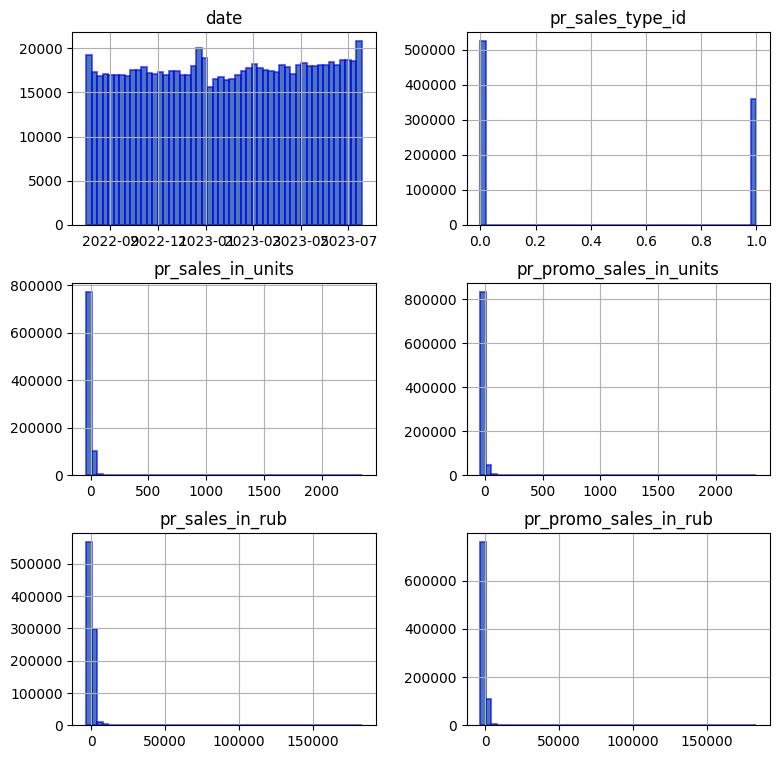

In [13]:
display_dataset_info(sales_df, 'Данные по продажам за скользящий год для обучения')

In [14]:
display(Markdown("**Подсчёт кол-ва уникальных значений в таблице магазинов**")) 

print('Кол-во магазинов, находящихся в торговле:', len(sales_df['st_id'].unique()))
print('Кол-во наименований товаров, находящихся в продаже:', len(sales_df['pr_sku_id'].unique()))

since = sales_df['date'].min().date()
to = sales_df['date'].max().date()
print('Временной период: от {} до {} ({} дня)'.format(since, to, (to-since).days+1))

**Подсчёт кол-ва уникальных значений в таблице магазинов**

Кол-во магазинов, находящихся в торговле: 12
Кол-во наименований товаров, находящихся в продаже: 1991
Временной период: от 2022-08-01 до 2023-07-18 (352 дня)


**Исследуем корреляцию признаков**

**Изучим корреляцию Пирсона и Крамера**
Первая позволяет улавливать линейные зависимости, вторя хорошо работает снелинейными и с категориальными признаками 

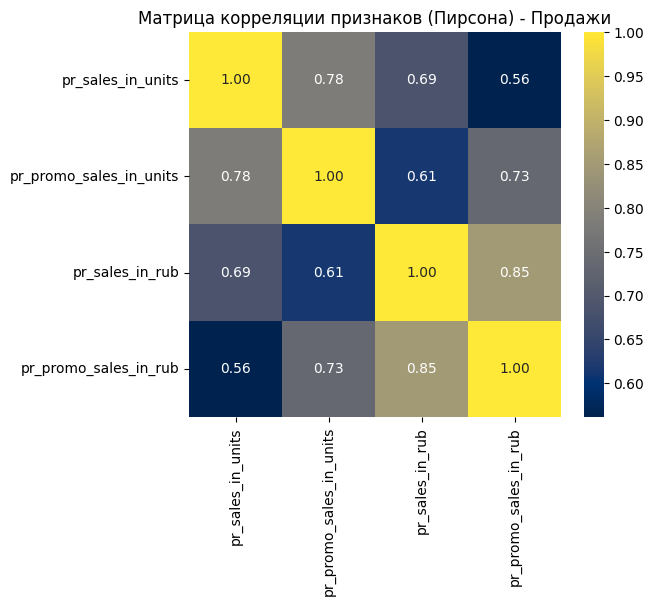

In [15]:
correlation_matrix_sales = sales_df.drop(['st_id', 'pr_sku_id', 'date', 'pr_sales_type_id'], axis=1)

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix_sales.corr(), annot=True, cmap='cividis', fmt=".2f")
plt.title("Матрица корреляции признаков (Пирсона) - Продажи")
plt.show()

CPU times: total: 5 s
Wall time: 43.9 s


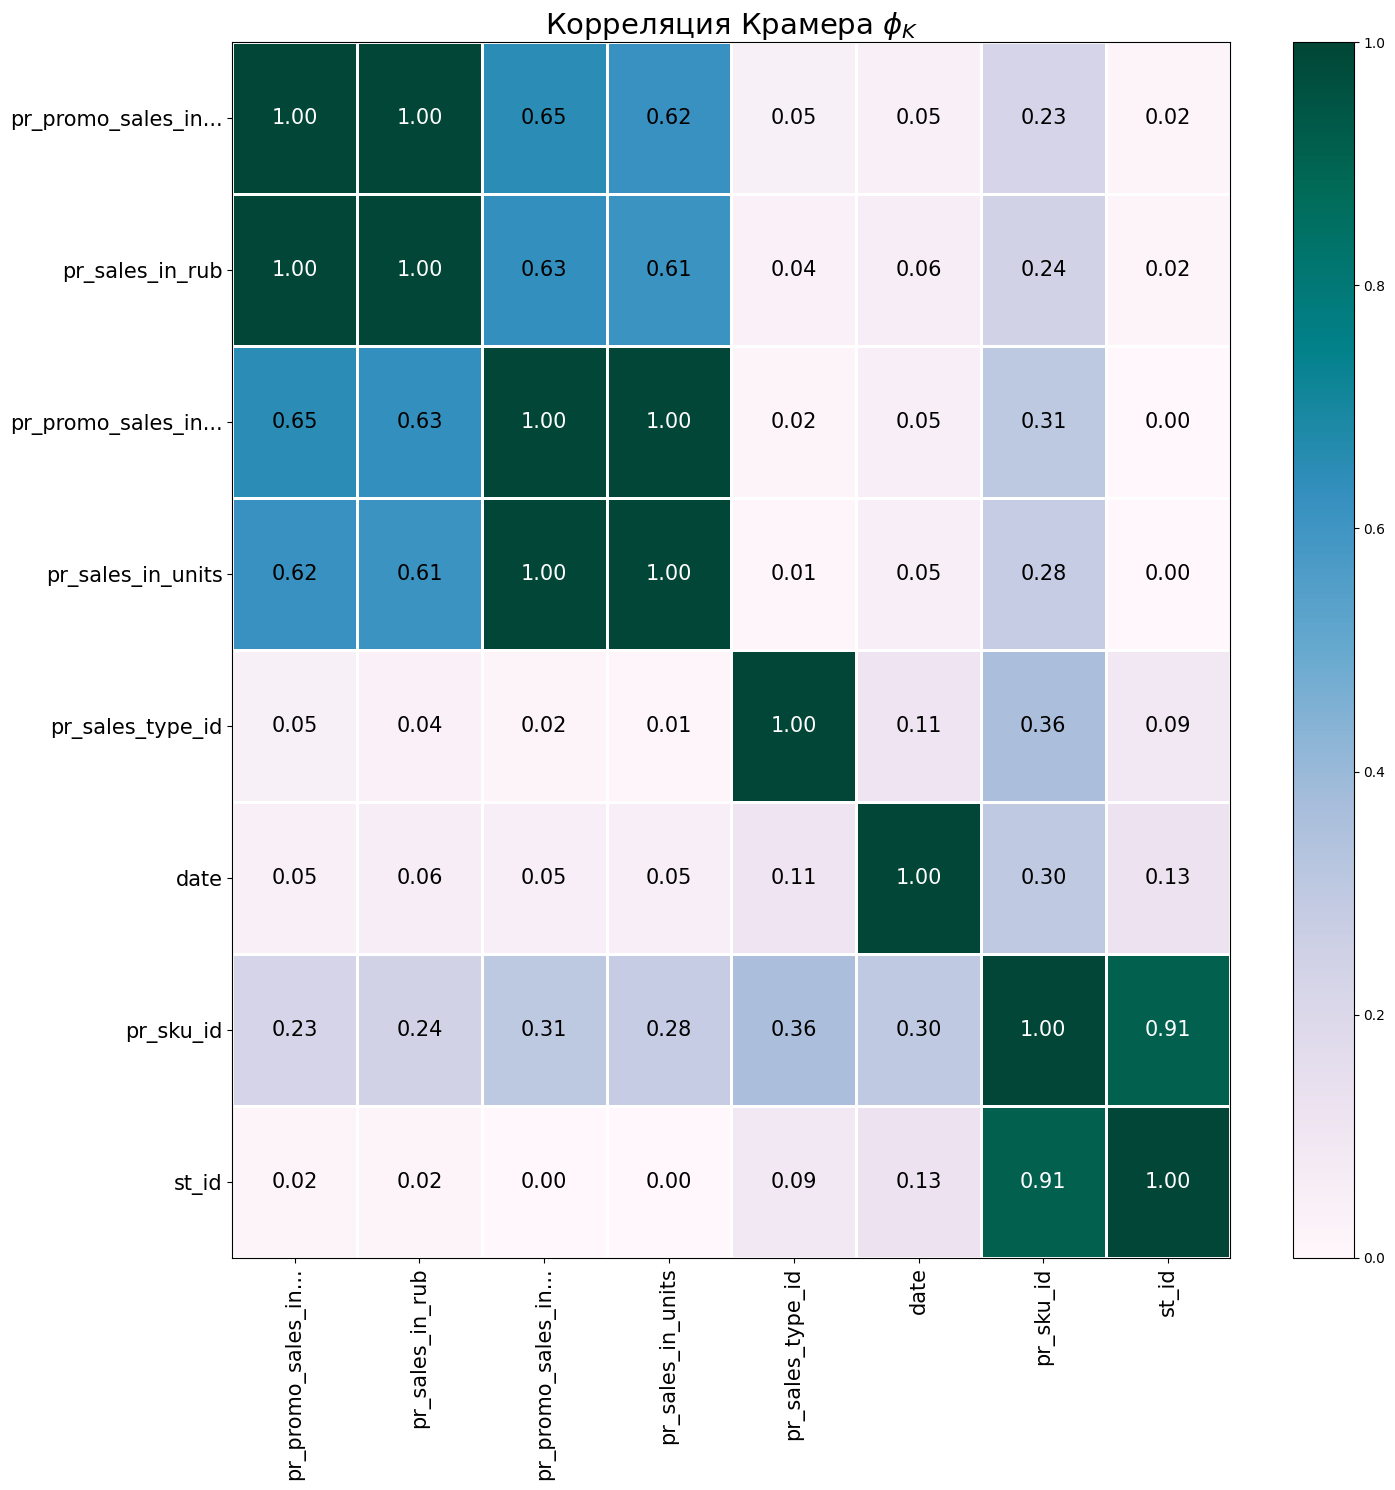

In [16]:
%%time

phik_matrix_plot(sales_df, ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub'])

Из матриц кореляции можно увидеть, что спрос на товары и выручка сильно связаны, что вполне логично. 
Промо продажи и общие продажи также связаны, поскольку общие продажи включают часть промо. 
На матрице Крамера видно также зависимость товара и магазина. 

**ВЫВОД:** 
- Tаблица содержит более 883+ тыс. записей о продажах. 
- Каждая запись фиксирует "Где? Что? Когда?" было продано, а также кол-во, стоимость и условия этих продаж (промо-акция / нет). - Фактически данные собраны за неполный год - 352 дня (подробности выше).
- Дата изначально хранилась в датасете в формате object, преобразовали в формат datetime64 для удобства работы.
- Присутствует сильная кореляця на товары и выручка (сильно связаны), что вполне логично. Промо продажи и общие продажи также связаны, поскольку общие продажи включают часть промо. На матрице Крамера видно также зависимость товара и магазина.

**ПЛАНЫ:**
- Стоит проконтролировать тип данных в столбцах: `pr_sales_in_units`, `pr_promo_sales_in_units`,	`pr_sales_in_rub`,	`pr_promo_sales_in_rub`
- Стоит проконтролировать целостность временной линии.
- Стоит ли устранить недочет с равенством `pr_sales_in_units` и `pr_promo_sales_in_units`, когда `pr_sales_type_id` равно 1?
- Возможно стоит изменить тип данных столбцов с датами на `datetime64`

### Пример файла с результатом работы модели прогноза спроса

Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по
умолчанию колонка заполнена нулями). Столбцы:
- `st_id` – захэшированное id магазина;
- `pr_sku_id` – захэшированное id товара;
- `date` – дата (день);
- `target` – спрос в ШТ.

In [17]:
display(sales_submission)
print(sales_submission.info())
print('Кол-во явных дубликатов:', sales_submission.duplicated().sum())

since = sales_submission['date'].min().date()
to = sales_submission['date'].max().date()
print('Временной период: от {} до {} ({} дней)'.format(since, to, (to-since).days+1))

,st_id,pr_sku_id,date,target
0,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-20,0
1,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,2023-07-20,0
2,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2023-07-20,0
3,16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,2023-07-20,0
4,16a5cdae362b8d27a1d8f8c7b78b4330,01e4734745e97e52d3213449e1a05dd7,2023-07-20,0
...,...,...,...,...
43689,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fd519eb13005448a303df1089505a42b,2023-08-01,0
43690,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fdb89dfd1a27256904eb5a5734252102,2023-08-01,0
43691,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fe50ae64d08d4f8245aaabc55d1baf79,2023-08-01,0
43692,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fe5d18ae6650335830e4c1dbd9e6ddb9,2023-08-01,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43694 entries, 0 to 43693
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   st_id      43694 non-null  object        
 1   pr_sku_id  43694 non-null  object        
 2   date       43694 non-null  datetime64[ns]
 3   target     43694 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.3+ MB
None
Кол-во явных дубликатов: 0
Временной период: от 2023-07-19 до 2023-08-01 (14 дней)


### Календарь праздников

**~~~~~~~ Данные по праздничным дням и пандемии ~~~~~~~**

**Общая информация о датасете**

,year,day,weekday,date,calday,holiday,covid
0,2015,1,4,2015-01-01,20150101,1,0
1,2015,2,5,2015-01-02,20150102,1,0
2,2015,3,6,2015-01-03,20150103,1,0
3,2015,4,7,2015-01-04,20150104,1,0
4,2015,5,1,2015-01-05,20150105,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   year     3653 non-null   int64         
 1   day      3653 non-null   int64         
 2   weekday  3653 non-null   int64         
 3   date     3653 non-null   datetime64[ns]
 4   calday   3653 non-null   int64         
 5   holiday  3653 non-null   int64         
 6   covid    3653 non-null   int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 199.9 KB


None

**Количество пропусков в датасете**

year       0
day        0
weekday    0
date       0
calday     0
holiday    0
covid      0
dtype: int64


**Дубликаты**

Количество явных дубликатов: 0
--------------------------------------------------


**Гистограммы числовых значений**

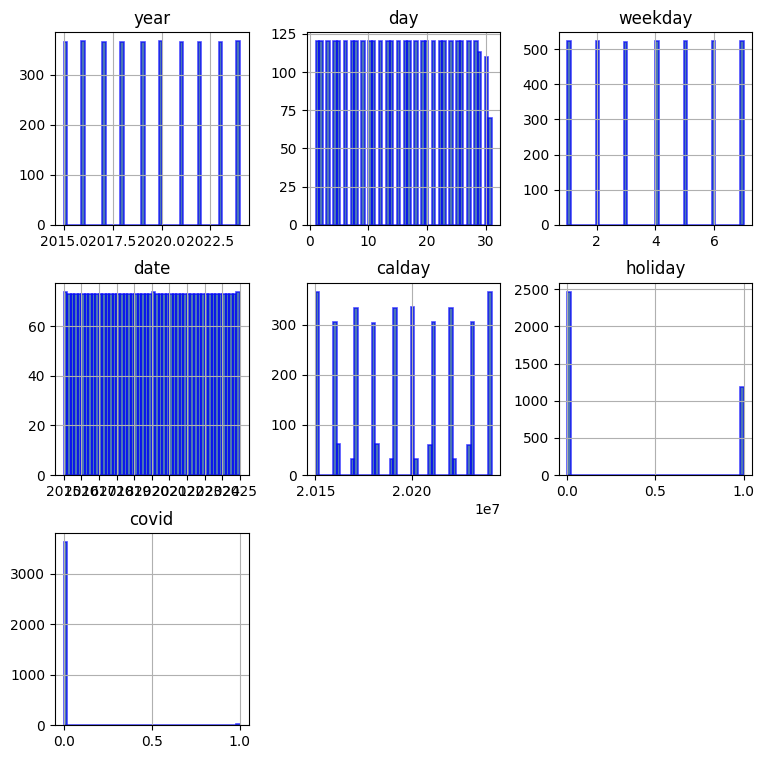

In [18]:
display_dataset_info(holidays, 'Данные по праздничным дням и пандемии')

In [19]:
holidays = holidays[['date','holiday']] # нам нужны только маркировки праздников, остальное лишнее
holidays.head(5)

,date,holiday
0,2015-01-01,1
1,2015-01-02,1
2,2015-01-03,1
3,2015-01-04,1
4,2015-01-05,1


**ВЫВОД:**
- Датасет календарных праздников представляет более продолжительный период, чем планируется для нашего анализа. Необходимо удет использовать только тот интервал, которй перескесется с нашим. 
- Дубликатов и пропусков нет, предобработка датасета не требуется. 

**ВЫВОД ПО ОЗНАКОМИТЕЛЬНОМУ АНАЛИЗУ ДАННЫХ:**
- наименование столбцов выполнено в едином стандарте,
- тип данных - соответствует, для дальнейшей работы даты переведены в формат datetime,
- пропуски и явные дубликаты - отсутствуют во всех датасетах.

Главным датасетом является `sales_df_train`, поскольку он содержит основную информацию для работы. В его состав входит около 880 000 записей о продажах, а если быть точнее: о поступлении и уходе денежных средств (выручка). Таким образом я хочу сказать, что каждый столбец с количественной информацией необходимо проверить на выбросы/аномалии и соответствие с заявленными данными. Этому будет посвящен следующий раздел.

___

## Разведочный анализ данных

Ориентировочный план анализа:

- Исследовать пропуски, выбросы и корреляции между товарами, заполнить пропуски, нивелировать выбросы,
- (День — Товар — Магазин — Продажа в штуках — Продажа в рублях — доля продаж по ПРОМО),
- Провести предобработку данных,
- Построить графики временных рядов.

### Распределение продаж

Два магазина на данный момент неактивны, рассмотрим исторические продажи в них. 

In [20]:
display(sales_df[sales_df['st_id'].isin(not_active_st_id)].head())

since = sales_df.loc[sales_df['st_id'].isin(not_active_st_id), 'date'].min().date()
to = sales_df.loc[sales_df['st_id'].isin(not_active_st_id), 'date'].max().date()
print('Временной период: от {} до {} ({} суток)'.format(since, to, (to-since).days+1))

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
678,1aa057313c28fa4a40c5bc084b11d276,5b26f85ccb23039364226f66f0366c66,2022-08-23,0,2.0,0.0,36.0,0.0
888,1aa057313c28fa4a40c5bc084b11d276,5aa2f6e00873f8c90b00cd15d670daa1,2022-08-04,1,2.0,2.0,115.0,115.0
3549,1aa057313c28fa4a40c5bc084b11d276,5b26f85ccb23039364226f66f0366c66,2022-08-17,0,4.0,0.0,89.0,0.0
5830,1aa057313c28fa4a40c5bc084b11d276,3a74a370c8eb032acb11ad9119242b8f,2022-08-15,0,1.0,0.0,65.0,0.0
9097,1aa057313c28fa4a40c5bc084b11d276,71c9661741caf40a92a32d1cc8206c04,2022-08-05,1,1.0,1.0,66.0,66.0


Временной период: от 2022-08-01 до 2022-09-08 (39 суток)


Кол-во записей о продажах в закрытых магазинах составляет меньше 0.1% от общего числа. Этого недостаточно для предсказания, тем более в этом нет необходимости. Эти данные стоит удалить, чтобы они не могли оказывать влияние на актуальные данные.

In [21]:
sales_df = sales_df[~sales_df['st_id'].isin(not_active_st_id)] 

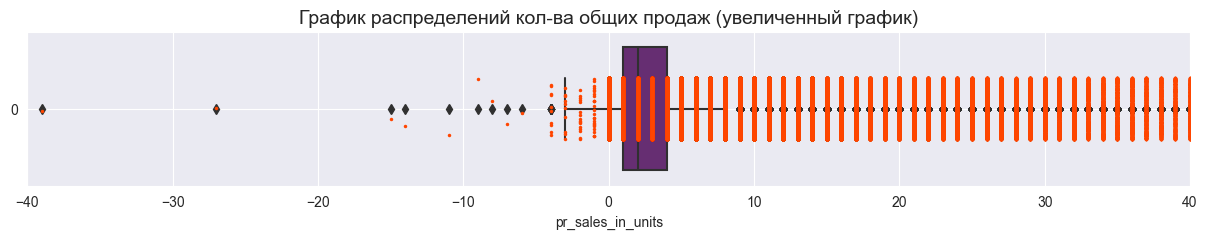

,pr_sales_in_units
count,882286.000000
mean,5.039530
std,13.408266
min,-39.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,2348.000000


In [22]:
sns.set_style("darkgrid")
plt.subplots(figsize=(15, 2))
ax = sns.boxplot(data=sales_df['pr_sales_in_units'], color='#6E237D', orient="h")
ax = sns.stripplot(data=sales_df['pr_sales_in_units'], orient="h", color="orangered", jitter=0.2, size=2.5)
plt.title('График распределений кол-ва общих продаж (увеличенный график)', fontsize=14)
plt.xlim(-40, 40)
plt.grid(True)
plt.show()

desc = sales_df['pr_sales_in_units'].describe().to_frame()
color = sns.light_palette("#6E237D", as_cmap=True) 
desc.style.background_gradient(cmap=color)

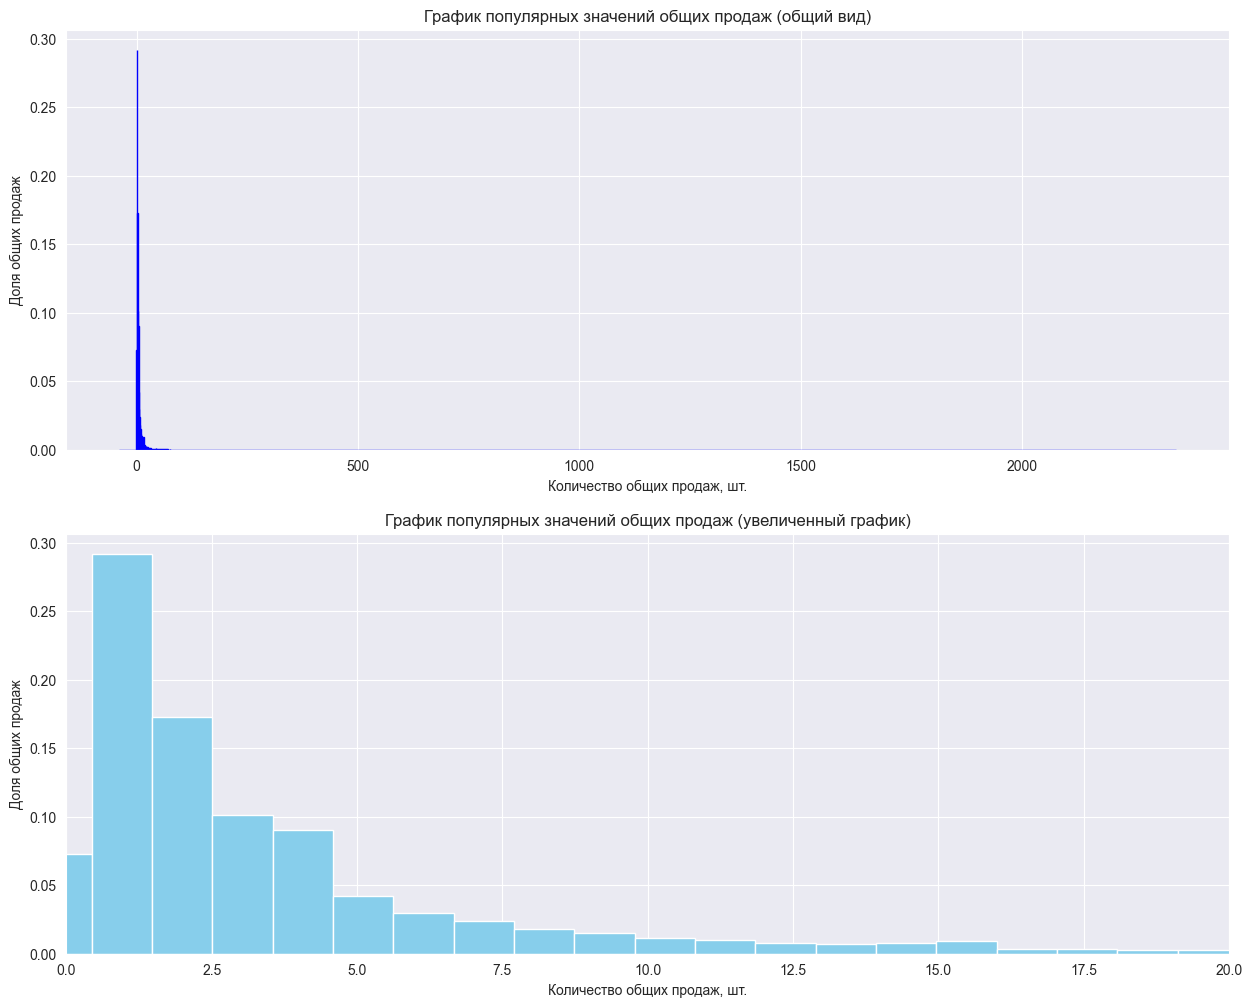

In [23]:
# распределение положительных значений общих продаж
fig, axs = plt.subplots(2, 1, figsize=(15, 12))

axs[0].hist(sales_df['pr_sales_in_units'], density=True, bins=2300, color='black', edgecolor='blue')
axs[0].set_title('График популярных значений общих продаж (общий вид)')
axs[0].set_ylabel('Доля общих продаж')
axs[0].set_xlabel('Количество общих продаж, шт.')
axs[0].grid(True)

axs[1].hist(sales_df['pr_sales_in_units'], density=True, bins=2300, color='skyblue')
axs[1].set_title('График популярных значений общих продаж (увеличенный график)')
axs[1].set_ylabel('Доля общих продаж')
axs[1].set_xlabel('Количество общих продаж, шт.')
axs[1].set_xlim(0, 20)
axs[1].grid(True)
plt.show()

In [24]:
# кол-во отрицательных и нулевых общих продаж
negative_sales_in_units = sales_df[sales_df['pr_sales_in_units'] <= 0].value_counts('pr_sales_in_units',
                                                                                    sort=False).to_frame()

negative_sales_in_units.loc['Total:','count'] = negative_sales_in_units['count'].sum()
negative_sales_in_units['count'] = negative_sales_in_units['count'].astype('int')

display(negative_sales_in_units)
del negative_sales_in_units

,count
pr_sales_in_units,
-39.0,1
-27.0,1
-15.0,1
-14.0,1
-11.0,1
-9.0,1
-8.0,1
-7.0,1
-6.0,1


- Столбец `pr_sales_in_units`, отображающий общее кол-во продаж товара содержит крайне большие значения, а так же отрицательные значения. 

- Крайне большие значение встречаются очень редко. Их присутствие сильно сказывается на распределении продаж. По этой причине от них необходимо избавиться. Границей между нормальными значениями и выбросами будет сумма 3-его квантиля и стандартного отклонения (Q3 + std) или воспользоваться правилом "трёх сигм" (mean + 3*std).

- Отрицательных значений не много 71 объект. Судя по частоте их встречи, предполагаю, что вероятней это возвраты. Чаще всего возвращали одну единицу товара, и значительно реже возвращали 6 и более товаров единовременно. Исключив отрицательные значения.
Аналогично можно поступить с "нулевыми" продажами, которых 453 объекта.

- Установив такие границы, выбросами и аномалиями будут признаны ~5% данных.

In [25]:
# общие продажи в "нормальных" пределах
min_sales = 0
max_sales = sales_df['pr_sales_in_units'].quantile(0.75) + sales_df['pr_sales_in_units'].std()

display(sales_df[(sales_df['pr_sales_in_units'] >= min_sales) & (sales_df['pr_sales_in_units'] <= max_sales)])

sales_df_train = sales_df[sales_df['pr_sales_in_units'] >= min_sales] # исключение отрицательных продаж
#                         (sales_df['pr_sales_in_units'] <= max_sales) # аномально большие продажи - остаются

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0
...,...,...,...,...,...,...,...,...
883010,c81e728d9d4c2f636f067f89cc14862c,a0150fefa71d6606d5e642fa0e7b8ad8,2022-12-13,1,1.0,1.0,33.0,33.0
883011,42a0e188f5033bc65bf8d78622277c4e,5b146d93f822459260216df28e572eca,2023-04-18,0,1.0,0.0,192.0,0.0
883012,42a0e188f5033bc65bf8d78622277c4e,c8bd18ea08d2f47cb0a7992f11ada9de,2022-08-16,0,5.0,0.0,970.0,0.0
883013,f7e6c85504ce6e82442c770f7c8606f0,b960c6ee5b5efa12e73f810204b561a8,2023-04-23,0,4.0,0.0,262.0,0.0


### Аномальные значения

В этом разделе будут проанализированы 2 условные группы:
- _возвраты_ - факт возврата отсутствует, но есть уход денежных средств,
- _неучтённые операции_ - факт продажи отсутствует, но есть поступление денежных средств,
- _убытки_ - факт продажи присутствует, но поступление денежных средств нет,
- _абсолютный ноль_ - никаких продаж, никаких денежных поступлений.

In [26]:
# возвраты
negative_sales_in_rub = sales_df[(sales_df['pr_sales_in_rub'] < 0) & (sales_df['pr_sales_in_units'] >= 0)]
display(negative_sales_in_rub)

sales_df = sales_df[~sales_df.index.isin(negative_sales_in_rub.index)] # исключение возвраты
del negative_sales_in_rub

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
43146,f7e6c85504ce6e82442c770f7c8606f0,699dc7822b719137e8124b728ab45fa3,2022-11-10,1,-0.0,-0.0,-32.0,-32.0
252813,6364d3f0f495b6ab9dcf8d3b5c6e0b01,480c8cfe6acee2ea1d6f1c63bb80f226,2022-12-04,1,-0.0,-0.0,-321.0,-321.0
333287,42a0e188f5033bc65bf8d78622277c4e,6464ba75236f5928023d75e46ea8a328,2022-11-16,0,-0.0,0.0,-290.0,0.0
455113,f7e6c85504ce6e82442c770f7c8606f0,fe50ae64d08d4f8245aaabc55d1baf79,2022-08-03,0,-0.0,0.0,-23.0,0.0
491005,f7e6c85504ce6e82442c770f7c8606f0,bf5f373eede102c71bf77874c78bdc59,2022-10-20,0,-0.0,0.0,-27.0,0.0
618130,42a0e188f5033bc65bf8d78622277c4e,d2de88fc7856a5f50c05e8d9b7a20838,2022-10-30,0,-0.0,0.0,-13.0,0.0
790016,6364d3f0f495b6ab9dcf8d3b5c6e0b01,0a2090e24b6ae62b0b0fcaa67a72b5a0,2023-07-06,0,0.0,0.0,-140.0,0.0
849426,c81e728d9d4c2f636f067f89cc14862c,4ce0eb956648ab3ff6bb0afa3158cc42,2023-01-31,0,-0.0,0.0,-51.0,0.0


In [27]:
# неучтённые операции (факт продажи - отсутствует, но есть поступление денежных средств)
zero_sales_in_units = sales_df[(sales_df['pr_sales_in_units'] == 0) & (sales_df['pr_sales_in_rub'] != 0)]
display(zero_sales_in_units)
zero_sales_in_units['pr_sales_in_rub'].describe().to_frame()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
6,f7e6c85504ce6e82442c770f7c8606f0,b75c7cbf7accdaea8a1a14781bb29870,2023-02-15,0,0.0,0.0,171.0,0.0
27,42a0e188f5033bc65bf8d78622277c4e,cfb54b1ce12bb3f9b6b9e2ea0b57414b,2022-11-10,0,0.0,0.0,91.0,0.0
28,f7e6c85504ce6e82442c770f7c8606f0,88d7313785c97631bf3df61e70636491,2022-11-30,0,0.0,0.0,79.0,0.0
32,fa7cdfad1a5aaf8370ebeda47a1ff1c3,b610088ddf586449793d3c6da70d4c56,2023-02-26,0,0.0,0.0,83.0,0.0
...,...,...,...,...,...,...,...,...
882978,fa7cdfad1a5aaf8370ebeda47a1ff1c3,a1f93a1aeb02759147d69276c70217db,2023-06-07,1,0.0,0.0,30.0,30.0
882979,6364d3f0f495b6ab9dcf8d3b5c6e0b01,cda72490a16c471e7a192a956f476e95,2023-04-11,0,0.0,0.0,62.0,0.0
882991,16a5cdae362b8d27a1d8f8c7b78b4330,7d945116ed12c2807d081df6f666ba37,2023-07-01,1,0.0,0.0,70.0,70.0
883004,42a0e188f5033bc65bf8d78622277c4e,143f62003066d8d4cc33d3e9161d114d,2022-12-25,1,0.0,0.0,41.0,41.0


,pr_sales_in_rub
count,66081.000000
mean,79.561811
std,61.323027
min,1.000000
25%,46.000000
50%,67.000000
75%,94.000000
max,832.000000


Возможно, _неучтённая сумма_ - это денежный остаток не внесённый в кассу в конце прошлого дня (пример №1). Или, _неучтённая сумма_ - это остаток не внесённый в кассу за текущий день (пример №2). Во всех примерах демонстрируется продажа одного товара в конкретном магазине, в конкретный день.

In [28]:
# Пример №1 - 4 апреля было продано 2 товара, а следующим днём 0. Но 5 апреля зафиксировано зачисление денег без продажи.
sales_df[(sales_df['st_id'] == '42a0e188f5033bc65bf8d78622277c4e') &
         (sales_df['pr_sku_id'] == '8e887cf8e64ab8e7173701a979476567') &
         ((sales_df['date'] == '2023-04-04') |
          (sales_df['date'] == '2023-04-05'))].sort_values(by='date')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
693245,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-04,1,2.0,2.0,268.0,268.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0


In [29]:
# Пример №2 - в течении дня была зафиксирована одна продажа, но два зачисления денежных средств. 
sales_df[(sales_df['st_id'] == '42a0e188f5033bc65bf8d78622277c4e') &
         (sales_df['pr_sku_id'] == 'cfb54b1ce12bb3f9b6b9e2ea0b57414b') &
         (sales_df['date'] == '2022-11-10')]

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
27,42a0e188f5033bc65bf8d78622277c4e,cfb54b1ce12bb3f9b6b9e2ea0b57414b,2022-11-10,0,0.0,0.0,91.0,0.0
118590,42a0e188f5033bc65bf8d78622277c4e,cfb54b1ce12bb3f9b6b9e2ea0b57414b,2022-11-10,1,1.0,1.0,206.0,206.0


In [30]:
# нетипичная ситуация: стоимость товара с промо-акцией дороже, чем без неё 
sales_df[(sales_df['st_id'] == 'fa7cdfad1a5aaf8370ebeda47a1ff1c3') &
         (sales_df['pr_sku_id'] == '6e822618c30449cfabec9b22a7de1425') &
         (sales_df['date'] == '2023-07-18')].sort_values(by='pr_sales_type_id')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
294320,fa7cdfad1a5aaf8370ebeda47a1ff1c3,6e822618c30449cfabec9b22a7de1425,2023-07-18,0,1.0,0.0,174.0,0.0
811860,fa7cdfad1a5aaf8370ebeda47a1ff1c3,6e822618c30449cfabec9b22a7de1425,2023-07-18,1,1.0,1.0,245.0,245.0


Возможны и другие объяснения, но для этого необходимо провести анализ совместно с соответствующим специалистом со стороны заказчика. Без этого аномалии нельзя объяснить однозначно, и соответственно, принять грамотное решение по их учёту. По этой причине все продажи содержащие поступление денежных средств, но без указания кол-ва товаров - будут исключены.

In [31]:
# убытки (факт продажи - присутствует, но поступление денежных средств нет)
zero_sales_in_rub = sales_df[(sales_df['pr_sales_in_units'] != 0) & (sales_df['pr_sales_in_rub']   == 0)]
display(zero_sales_in_rub)

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
30,f7e6c85504ce6e82442c770f7c8606f0,3474f0e025c7deb7e127a35763bc5512,2023-06-06,1,8.0,8.0,0.0,0.0
6313,53e19f3dbb211f20b20b45668303c1b6,ee21c04f96ab30a8b3ca761e57e016ca,2022-11-09,1,1.0,1.0,0.0,0.0
7432,c81e728d9d4c2f636f067f89cc14862c,90252502ab29331e94fd3113f11c58e0,2022-12-27,1,2.0,2.0,0.0,0.0
8153,f7e6c85504ce6e82442c770f7c8606f0,4e3d5c9fab3fc51a4857846fea3d2e57,2022-12-19,1,1.0,1.0,0.0,0.0
8931,f7e6c85504ce6e82442c770f7c8606f0,0f152427918d29bb1081834c1d375a48,2022-10-28,1,2.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...
876801,1ecfb463472ec9115b10c292ef8bc986,525526d5b2169462195c44d49fff4a44,2022-10-22,1,1.0,1.0,0.0,0.0
878163,fa7cdfad1a5aaf8370ebeda47a1ff1c3,27e8978c9e8b7146c462feb7d24f5637,2022-10-27,1,9.0,9.0,0.0,0.0
882360,6364d3f0f495b6ab9dcf8d3b5c6e0b01,2dc922d957188fb51dd2bd50ec9b555a,2022-10-29,1,12.0,12.0,0.0,0.0
882380,f7e6c85504ce6e82442c770f7c8606f0,9da31b9d3cf407cd724c65b7dfed00ee,2022-11-27,1,3.0,3.0,0.0,0.0


In [32]:
# абсолютно нулевые продажи
absolut_zero_sale = sales_df[(sales_df['pr_sales_in_units'] == 0) &
                             (sales_df['pr_sales_in_rub']   == 0)]

print('Уникальные значения в колонке "pr_sales_in_units"      :', absolut_zero_sale['pr_sales_in_units'].unique())
print('Уникальные значения в колонке "pr_promo_sales_in_units":', absolut_zero_sale['pr_promo_sales_in_units'].unique())
print('Уникальные значения в колонке "pr_sales_in_rub"        :', absolut_zero_sale['pr_sales_in_rub'].unique())
print('Уникальные значения в колонке "pr_promo_sales_in_rub"  :', absolut_zero_sale['pr_promo_sales_in_rub'].unique())

display(absolut_zero_sale)

Уникальные значения в колонке "pr_sales_in_units"      : [0.]
Уникальные значения в колонке "pr_promo_sales_in_units": [0.]
Уникальные значения в колонке "pr_sales_in_rub"        : [0.]
Уникальные значения в колонке "pr_promo_sales_in_rub"  : [0.]


,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
1221,f7e6c85504ce6e82442c770f7c8606f0,67dcedaa1090d67cef7afe3fb36945b0,2022-12-19,1,0.0,0.0,0.0,0.0
3845,fa7cdfad1a5aaf8370ebeda47a1ff1c3,5b146d93f822459260216df28e572eca,2023-04-04,1,0.0,0.0,0.0,0.0
6454,f7e6c85504ce6e82442c770f7c8606f0,d4e879aca51d48e0feba3112f0d1b8cd,2023-02-28,1,0.0,0.0,0.0,0.0
11534,16a5cdae362b8d27a1d8f8c7b78b4330,0a68dd43c227b0e66d52665d6c3ca8ba,2022-10-29,1,0.0,0.0,0.0,0.0
13646,f7e6c85504ce6e82442c770f7c8606f0,7708533936cc9e00273ae5700d3bc8d5,2023-01-03,1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
871590,53e19f3dbb211f20b20b45668303c1b6,f32fd3acc6b050e411d97e4235b12102,2023-05-16,1,0.0,0.0,0.0,0.0
876662,c81e728d9d4c2f636f067f89cc14862c,65904bcd52a06cd64e57fc80b4b042d0,2023-02-16,1,0.0,0.0,0.0,0.0
878957,c81e728d9d4c2f636f067f89cc14862c,364196813f3b746270a9b27bd76149c9,2022-11-03,0,0.0,0.0,0.0,0.0
879518,6364d3f0f495b6ab9dcf8d3b5c6e0b01,8cad09283d1d6c5fb08daec8a576a72d,2022-10-20,1,0.0,0.0,0.0,0.0


In [33]:
# исключение аномалий
sales_df = sales_df[~sales_df.index.isin(zero_sales_in_units.index)]
sales_df = sales_df[~sales_df.index.isin(zero_sales_in_rub.index)]
sales_df = sales_df[~sales_df.index.isin(absolut_zero_sale.index)]

print('Остаточная численность датасета:', sales_df.shape[0])

del zero_sales_in_units
del zero_sales_in_rub
del absolut_zero_sale

Остаточная численность датасета: 814951


**Предположение:** Если промо-акция действует в течении всего дня, то все товар можно приобрести либо по фактической цене, либо по промо-цене. Промежуточных вариантов нет. В таком случа столбцы `pr_promo_sales_in_units` и `pr_promo_sales_in_rub` не играют важной роли. Достаточно информации о наличии/отсутствии акции из столбца `pr_sales_type_id`.

Однако от бизнеса мы знаем, что товары собственного производства утилизируют, если не успели распродать за день (поскольку есть риск по срокам годности). 

В процессе анализа предположение не подтвердилось. В течение всего дня, товар можно приобрести как по фактической стоимости, так и по сниженной, воспользовавшись картой постоянного покупателя или другими привилегиями/льготами. Более подробному разбору посвящён следующий раздел.

### Неявные дубликаты

Под ними подразумевается раздвоение продаже товара с промо и без. Для каждого случая отдельная строчка. Из общего объёма датасета ~300 000 объектов (36%) - продублированы. Проблема заключается в том, что столбец `pr_sales_in_units` - изначально не показывает общее кол-во продаж. Ниже приведёт примеры демонстрирующий эту проблему и объём данных.

Исключением являются случае в которых все продажи были зафиксированы по одной цене (либо с промо, либо без).

In [34]:
# неявные дубликаты. необходима группировка
sales_df[sales_df[['st_id', 'pr_sku_id', 'date']].duplicated(keep=False)].sort_values(by=['date',
                                                                                          'st_id',
                                                                                          'pr_sku_id',
                                                                                          'pr_sales_type_id'])

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
728531,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2022-08-01,0,4.0,0.0,712.0,0.0
550849,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2022-08-01,1,2.0,2.0,383.0,383.0
129271,16a5cdae362b8d27a1d8f8c7b78b4330,08dc3a654abf4087cedd4b03684c5862,2022-08-01,0,4.0,0.0,131.0,0.0
666268,16a5cdae362b8d27a1d8f8c7b78b4330,08dc3a654abf4087cedd4b03684c5862,2022-08-01,1,1.0,1.0,31.0,31.0
67581,16a5cdae362b8d27a1d8f8c7b78b4330,13c11f36d7304f758d93ba433bf2b774,2022-08-01,0,6.0,0.0,315.0,0.0
...,...,...,...,...,...,...,...,...
196085,fa7cdfad1a5aaf8370ebeda47a1ff1c3,d5bfeecaaa47887a4b92d17fa55c2e18,2023-07-18,1,6.0,6.0,64.0,64.0
86039,fa7cdfad1a5aaf8370ebeda47a1ff1c3,e18afd243d50032a8a36e3f1d5d99d53,2023-07-18,0,5.0,0.0,407.0,0.0
496830,fa7cdfad1a5aaf8370ebeda47a1ff1c3,e18afd243d50032a8a36e3f1d5d99d53,2023-07-18,1,3.0,3.0,205.0,205.0
368850,fa7cdfad1a5aaf8370ebeda47a1ff1c3,f165b731ecfaac92a2f7ba92d07ccdaa,2023-07-18,0,2.0,0.0,394.0,0.0


Далее приведены примеры доказывающие, что учёт продаж с промо или без происходит индивидуально. Формируется отдельная запись.

In [35]:
# Пример №1. Без промо - 1, с промо - 1.
sales_df[(sales_df['st_id'] == 'fa7cdfad1a5aaf8370ebeda47a1ff1c3') &
         (sales_df['pr_sku_id'] == '998f28b5baa9b34f23eaf2e08ed2d63c') &
         (sales_df['date'] == '2023-07-18')].sort_values(by='pr_sales_type_id')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
74463,fa7cdfad1a5aaf8370ebeda47a1ff1c3,998f28b5baa9b34f23eaf2e08ed2d63c,2023-07-18,0,1.0,0.0,120.0,0.0
190315,fa7cdfad1a5aaf8370ebeda47a1ff1c3,998f28b5baa9b34f23eaf2e08ed2d63c,2023-07-18,1,1.0,1.0,58.0,58.0


In [36]:
# Пример №2. Без промо - 1, с промо - 2.
sales_df[(sales_df['st_id'] == 'fa7cdfad1a5aaf8370ebeda47a1ff1c3') &
         (sales_df['pr_sku_id'] == '9da31b9d3cf407cd724c65b7dfed00ee') &
         (sales_df['date'] == '2023-07-18')].sort_values(by='pr_sales_type_id')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
539176,fa7cdfad1a5aaf8370ebeda47a1ff1c3,9da31b9d3cf407cd724c65b7dfed00ee,2023-07-18,0,1.0,0.0,21.0,0.0
66290,fa7cdfad1a5aaf8370ebeda47a1ff1c3,9da31b9d3cf407cd724c65b7dfed00ee,2023-07-18,1,2.0,2.0,40.0,40.0


In [37]:
# Пример №3. Без промо - 1, с промо - 19.
sales_df[(sales_df['st_id'] == 'fa7cdfad1a5aaf8370ebeda47a1ff1c3') &
         (sales_df['pr_sku_id'] == '71c9661741caf40a92a32d1cc8206c04') &
         (sales_df['date'] == '2023-07-18')].sort_values(by='pr_sales_type_id')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
249573,fa7cdfad1a5aaf8370ebeda47a1ff1c3,71c9661741caf40a92a32d1cc8206c04,2023-07-18,0,1.0,0.0,69.0,0.0
238814,fa7cdfad1a5aaf8370ebeda47a1ff1c3,71c9661741caf40a92a32d1cc8206c04,2023-07-18,1,19.0,19.0,1194.0,1194.0


Решением проблемы могут быть две варианта:
1. Объединением дублирующих записей в одну: Суммированием общих продаж и выручки, а так же обязательный расчёт доли промо-товаров.
2. Разделение всего датасета на два малых по признаку наличия промо-акции `pr_sales_type_id`.

Учёт наличия промо-акции `pr_sales_type_id` обязателен для корректного обучения модели.

In [38]:
# группировка по id магазина, товара и дате
group_sales = sales_df.groupby(['st_id', 'pr_sku_id', 'date'])[['pr_sales_in_units',
                                                                'pr_promo_sales_in_units',
                                                                'pr_sales_in_rub',
                                                                'pr_promo_sales_in_rub']].sum()

group_sales.reset_index(inplace=True)
display(group_sales.head(10))

,st_id,pr_sku_id,date,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-07,1.0,1.0,81.0,81.0
1,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-11,1.0,1.0,81.0,81.0
2,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-12,1.0,1.0,81.0,81.0
3,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-29,1.0,0.0,146.0,0.0
4,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-05-24,1.0,0.0,146.0,0.0
5,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-06-05,1.0,0.0,146.0,0.0
6,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-06-20,1.0,0.0,146.0,0.0
7,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-06-24,1.0,1.0,132.0,132.0
8,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-06-25,1.0,0.0,146.0,0.0
9,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-06-29,1.0,0.0,146.0,0.0


In [39]:
# контроль группировки
all = sales_df.shape[0]
dupls = sales_df[sales_df[['st_id', 'pr_sku_id', 'date']].duplicated(keep=False)].shape[0]
no_dupls = all - dupls

display(Markdown("**Контрольные группировки**")) 
print('Исходное кол-во объектов:         ', all)
print('Кол-во неявных дубликатов:        ', dupls)
print('Кол-во объектов без дубликатов:   ', no_dupls)
print('Кол-во объектов после группировки:', no_dupls + dupls//2)
print('Группировка прошла успешно:       ', group_sales.shape[0] == (no_dupls + dupls//2))

**Контрольные группировки**

Исходное кол-во объектов:          814951
Кол-во неявных дубликатов:         307810
Кол-во объектов без дубликатов:    507141
Кол-во объектов после группировки: 661046
Группировка прошла успешно:        True


In [40]:
# создание новых столбцов
group_sales['promo_in_units'] = group_sales['pr_promo_sales_in_units'] / group_sales['pr_sales_in_units']
group_sales['promo_in_rub']   = group_sales['pr_promo_sales_in_rub']   / group_sales['pr_sales_in_rub']

group_sales['price'] = ((group_sales['pr_sales_in_rub'] * (1 - group_sales['promo_in_rub'])) /
                        (group_sales['pr_sales_in_units'] * (1 - group_sales['promo_in_units'])))

group_sales['promo_price'] = ((group_sales['pr_sales_in_rub'] * group_sales['promo_in_rub']) /
                              (group_sales['pr_sales_in_units'] * group_sales['promo_in_units']))


group_sales.drop(['pr_promo_sales_in_units',
                  'pr_promo_sales_in_rub',
                  'promo_in_units',
                  'promo_in_rub'], axis=1, inplace=True)

display(group_sales)

,st_id,pr_sku_id,date,pr_sales_in_units,pr_sales_in_rub,price,promo_price
0,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-07,1.0,81.0,NaN,81.0
1,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-11,1.0,81.0,NaN,81.0
2,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-12,1.0,81.0,NaN,81.0
3,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-29,1.0,146.0,146.00,NaN
4,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-05-24,1.0,146.0,146.00,NaN
...,...,...,...,...,...,...,...
661041,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff62e7bffaca5e0ac8029cd29298c8c3,2023-01-12,4.0,143.0,35.75,NaN
661042,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff62e7bffaca5e0ac8029cd29298c8c3,2023-01-13,4.0,116.0,29.00,NaN
661043,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff62e7bffaca5e0ac8029cd29298c8c3,2023-01-14,4.0,104.0,NaN,26.0
661044,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff62e7bffaca5e0ac8029cd29298c8c3,2023-01-16,4.0,115.0,28.75,NaN


Новые столбцы:
- `promo_in_units` - доля промо-товаров среди общего количества продаж.
- `promo_in_rub` - доля промо-выручки среди общего объёма денежных средств.
- `price` - цена товара в день продажи
- `promo_price` - цена товара по промо-акции

### Анализ популярных товаров

,pr_sku_id,pr_sales_in_units,pr_sales_in_rub
0,62d4af457ba2540ce0898a211c0cd17a,125033.0,1996443.0
1,ced0c1a84924c982a6403870c54b99ca,121618.0,3834866.0
2,c0e3f3bd815a862433bc3399c487926b,117922.0,14904282.0
3,4b083e10f6cd2f4360c5425d05be6386,91168.0,7997036.0
4,d5bfeecaaa47887a4b92d17fa55c2e18,81862.0,592271.0
...,...,...,...
1967,8889a874ab21eb8fceaa11e7be87fc10,1.0,57.0
1968,88a5b9c2dbe7565b25cb978ebf21ec1b,1.0,211.0
1969,8b5665bda2d2a46ee3d2bef26789f7a0,1.0,61.0
1970,002c3a40ac50dc870f1ff386f11f5bae,1.0,167.0


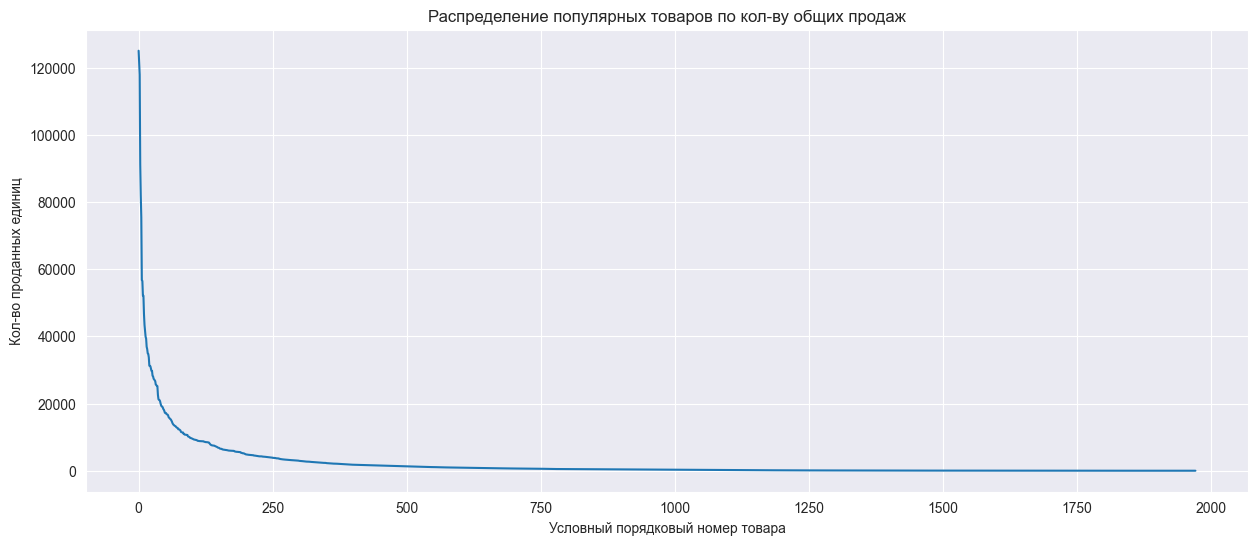

In [41]:
# ТОП товаров по кол-ву продаж
group_sku = group_sales.groupby('pr_sku_id')[['pr_sales_in_units', 'pr_sales_in_rub']].sum()

top_sku_by_units = group_sku.sort_values('pr_sales_in_units', ascending=False).reset_index(inplace=False)
display(top_sku_by_units)

top_sku_by_units['pr_sales_in_units'].plot(title='Распределение популярных товаров по кол-ву общих продаж',
                                           xlabel='Условный порядковый номер товара',
                                           ylabel='Кол-во проданных единиц',
                                           figsize=FIGSIZE,
                                           grid=True);

,pr_sku_id,pr_sales_in_units,pr_sales_in_rub
0,c0e3f3bd815a862433bc3399c487926b,117922.0,14904282.0
1,4e824a65fbd01f1708131bd247842688,25181.0,12897895.0
2,5fb6bfa7b7d9a415d5f95d3951e2a35d,56480.0,8289040.0
3,4b083e10f6cd2f4360c5425d05be6386,91168.0,7997036.0
4,4a04104f09c6ea3e807666cce0c294d5,13303.0,7021850.0
...,...,...,...
1967,48d8820abfb51f47e0975f797b1497e3,2.0,37.0
1968,5c70177d1170a79b9ff82d4459027c44,1.0,33.0
1969,48bb4fc3b178d1131f477296faebf138,2.0,30.0
1970,672981bfc413b6063b1dcbb8c1a39e61,1.0,27.0


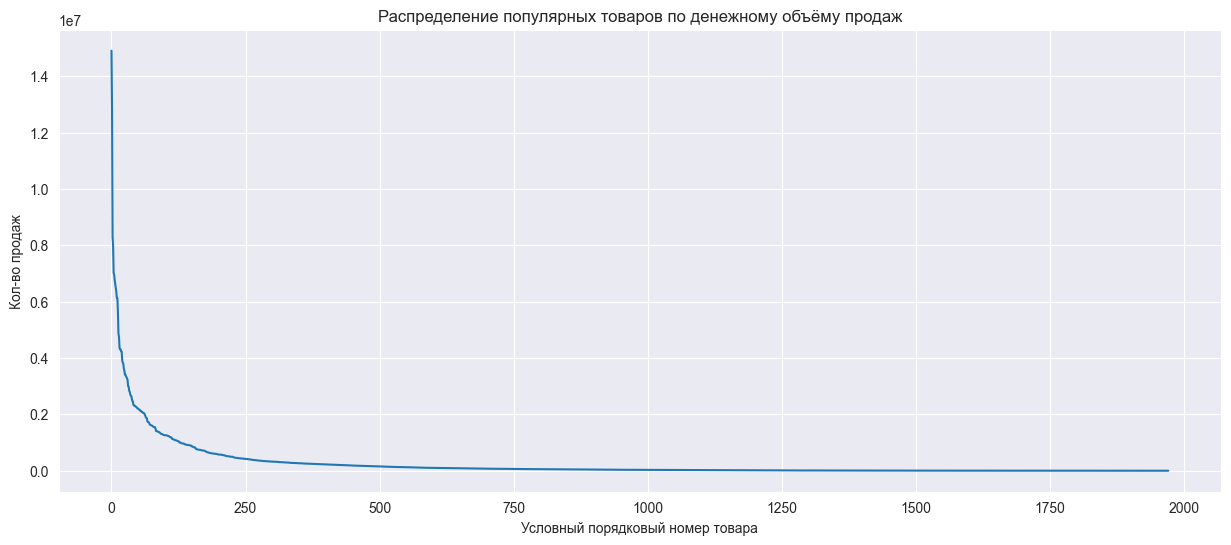

In [42]:
# ТОП товаров по денежному объёму продаж
top_sku_by_rub = group_sku.sort_values('pr_sales_in_rub', ascending=False).reset_index(inplace=False)
display(top_sku_by_rub)

top_sku_by_rub['pr_sales_in_rub'].plot(title='Распределение популярных товаров по денежному объёму продаж',
                                       xlabel='Условный порядковый номер товара',
                                       ylabel='Кол-во продаж',
                                       figsize=FIGSIZE,
                                       grid=True);

На этом графиках наглядно можно убедиться, что из почти двух тысячного ассортимента, лишь пара сотен товаров составляет большинство продаж. На этом этапе произойдёт отбор популярных товаров, с которыми продолжится дальнейшая работы.

Можно подойти к вопросу формирования top-N с другой стороны. Критериев для отбора может быть несколько. В первую очередь это _количество продаж_ или _денежный объём_. По мере увеличения ТОПа, перечень лидеров будет пересекаться в том и другом списке.

In [43]:
# сравнение ТОПов
for n in range(50, 251, 25):
    top_n_sku_by_units = top_sku_by_units.head(n)
    top_n_sku_by_rub   = top_sku_by_rub.head(n)
    print('TOP-{} - Пересечение товаров: {:.1%}'.format(n, top_n_sku_by_units.merge(top_n_sku_by_rub).shape[0] / n))

print('\nДоля выручки TOP-150: {:.1%} всех товаров.'.format(top_sku_by_units.head(150)['pr_sales_in_rub'].sum() /
                                                            group_sku['pr_sales_in_rub'].sum()))

top_150_sku_by_units = top_sku_by_units.head(150)['pr_sku_id'].values

del group_sku
del top_sku_by_rub
del top_sku_by_units
del top_n_sku_by_rub
del top_n_sku_by_units

TOP-50 - Пересечение товаров: 58.0%
TOP-75 - Пересечение товаров: 61.3%
TOP-100 - Пересечение товаров: 62.0%
TOP-125 - Пересечение товаров: 64.0%
TOP-150 - Пересечение товаров: 69.3%
TOP-175 - Пересечение товаров: 69.1%
TOP-200 - Пересечение товаров: 69.0%
TOP-225 - Пересечение товаров: 70.7%
TOP-250 - Пересечение товаров: 70.8%

Доля выручки TOP-150: 59.8% всех товаров.


Так вот для top-150 эти списки похожи на 69%, что является максимальным значением (см. фото). Я считаю, это ещё один ориентир для ТОПа продуктов. При этом аргументированный. Но предпочтение остаётся за кол-ом проданных товаров, поскольку именну эту величину необходимо предсказать, а так же это абсолютная величина в отличии от денежной суммы. Она зависит от цены товара.

### Анализ сводной таблицы признаков 

**Создадим общий датафрейм со всеми признаками** 

Объединяем датафреймы по ключевым столбцам pr_sku_id и st_id, используя метод merge. Используем аргумент how='left', чтобы сохранить все строки из sales_df, а данные из других таблиц будут добавлены к соответствующим строкам, если есть совпадения.

In [44]:
sales_df = sales_df.merge(holidays, on='date', how='left')
merged_df = sales_df.merge(goods_df, on='pr_sku_id', how='left')
merged_df = merged_df.merge(markets_df, on='st_id', how='left')

После обьединения датасетов перенесем столбец `data` в индексы и проверим сортировку по порядку. 

**~~~~~~~ Сводная таблица данных ~~~~~~~**

**Общая информация о датасете**

,st_id,pr_sku_id,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,holiday,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
date,,,,,,,,,,,,,,,,,,
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,62d4af457ba2540ce0898a211c0cd17a,0,89.0,0.0,1294.0,0.0,0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,0cc57d9daaa686e94f9ab541f3026121,1,9.0,9.0,906.0,906.0,0,6512bd43d9caa6e02c990b0a82652dca,e58cc5ca94270acaceed13bc82dfedf7,120e4b609af49ff7b17c3b90e7a28435,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,9d678e20f4a45c137a0492034506d432,0,13.0,0.0,2281.0,0.0,0,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,3d15a2a1c540356f9716dc265dd92382,1,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1
2022-08-01,c81e728d9d4c2f636f067f89cc14862c,5d560ea997068115892d2f0bd7cf91c3,0,5.0,0.0,825.0,0.0,0,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,a13b7a6b8e80d44d044c257a08ecccca,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
2022-08-01,f7e6c85504ce6e82442c770f7c8606f0,bd78bd39035162d425a5c8ac8b088fc6,0,6.0,0.0,628.0,0.0,0,aab3238922bcc25a6f606eb525ffdc56,46771d1f432b42343f56f791422a4991,38cc804f2e8d4b18785b84c68517eadf,1,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 814951 entries, 2022-08-01 to 2023-07-18
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    814951 non-null  object 
 1   pr_sku_id                814951 non-null  object 
 2   pr_sales_type_id         814951 non-null  int64  
 3   pr_sales_in_units        814951 non-null  float64
 4   pr_promo_sales_in_units  814951 non-null  float64
 5   pr_sales_in_rub          814951 non-null  float64
 6   pr_promo_sales_in_rub    814951 non-null  float64
 7   holiday                  814951 non-null  int64  
 8   pr_group_id              814951 non-null  object 
 9   pr_cat_id                814951 non-null  object 
 10  pr_subcat_id             814951 non-null  object 
 11  pr_uom_id                814951 non-null  int64  
 12  st_city_id               814951 non-null  object 
 13  st_division_code         814951 non-null  o

None

**Количество пропусков в датасете**

st_id                      0
pr_sku_id                  0
pr_sales_type_id           0
pr_sales_in_units          0
pr_promo_sales_in_units    0
pr_sales_in_rub            0
pr_promo_sales_in_rub      0
holiday                    0
pr_group_id                0
pr_cat_id                  0
pr_subcat_id               0
pr_uom_id                  0
st_city_id                 0
st_division_code           0
st_type_format_id          0
st_type_loc_id             0
st_type_size_id            0
st_is_active               0
dtype: int64


**Дубликаты**

Количество явных дубликатов: 215299
--------------------------------------------------


**Гистограммы числовых значений**

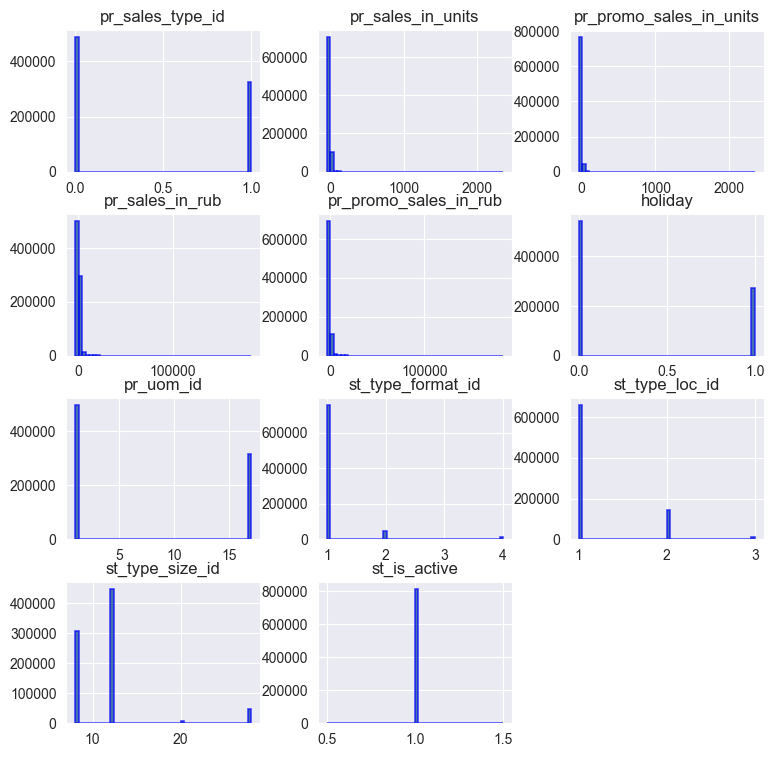

In [45]:
merged_df = merged_df.set_index('date')
merged_df.sort_index(inplace = True)

display_dataset_info(merged_df, 'Сводная таблица данных')

- Обьединение датасетов прошло нормально, пропуски отсутствуют,
- К общей таблице добавлены праздники (категориальный признак),
- Дубликат вероятее всего появились после переноса даты в индекс, потому в них попали похожие продажи, совершенные в разные дни.

**Изучим корреляцию признаков в сводной таблице признаков** 

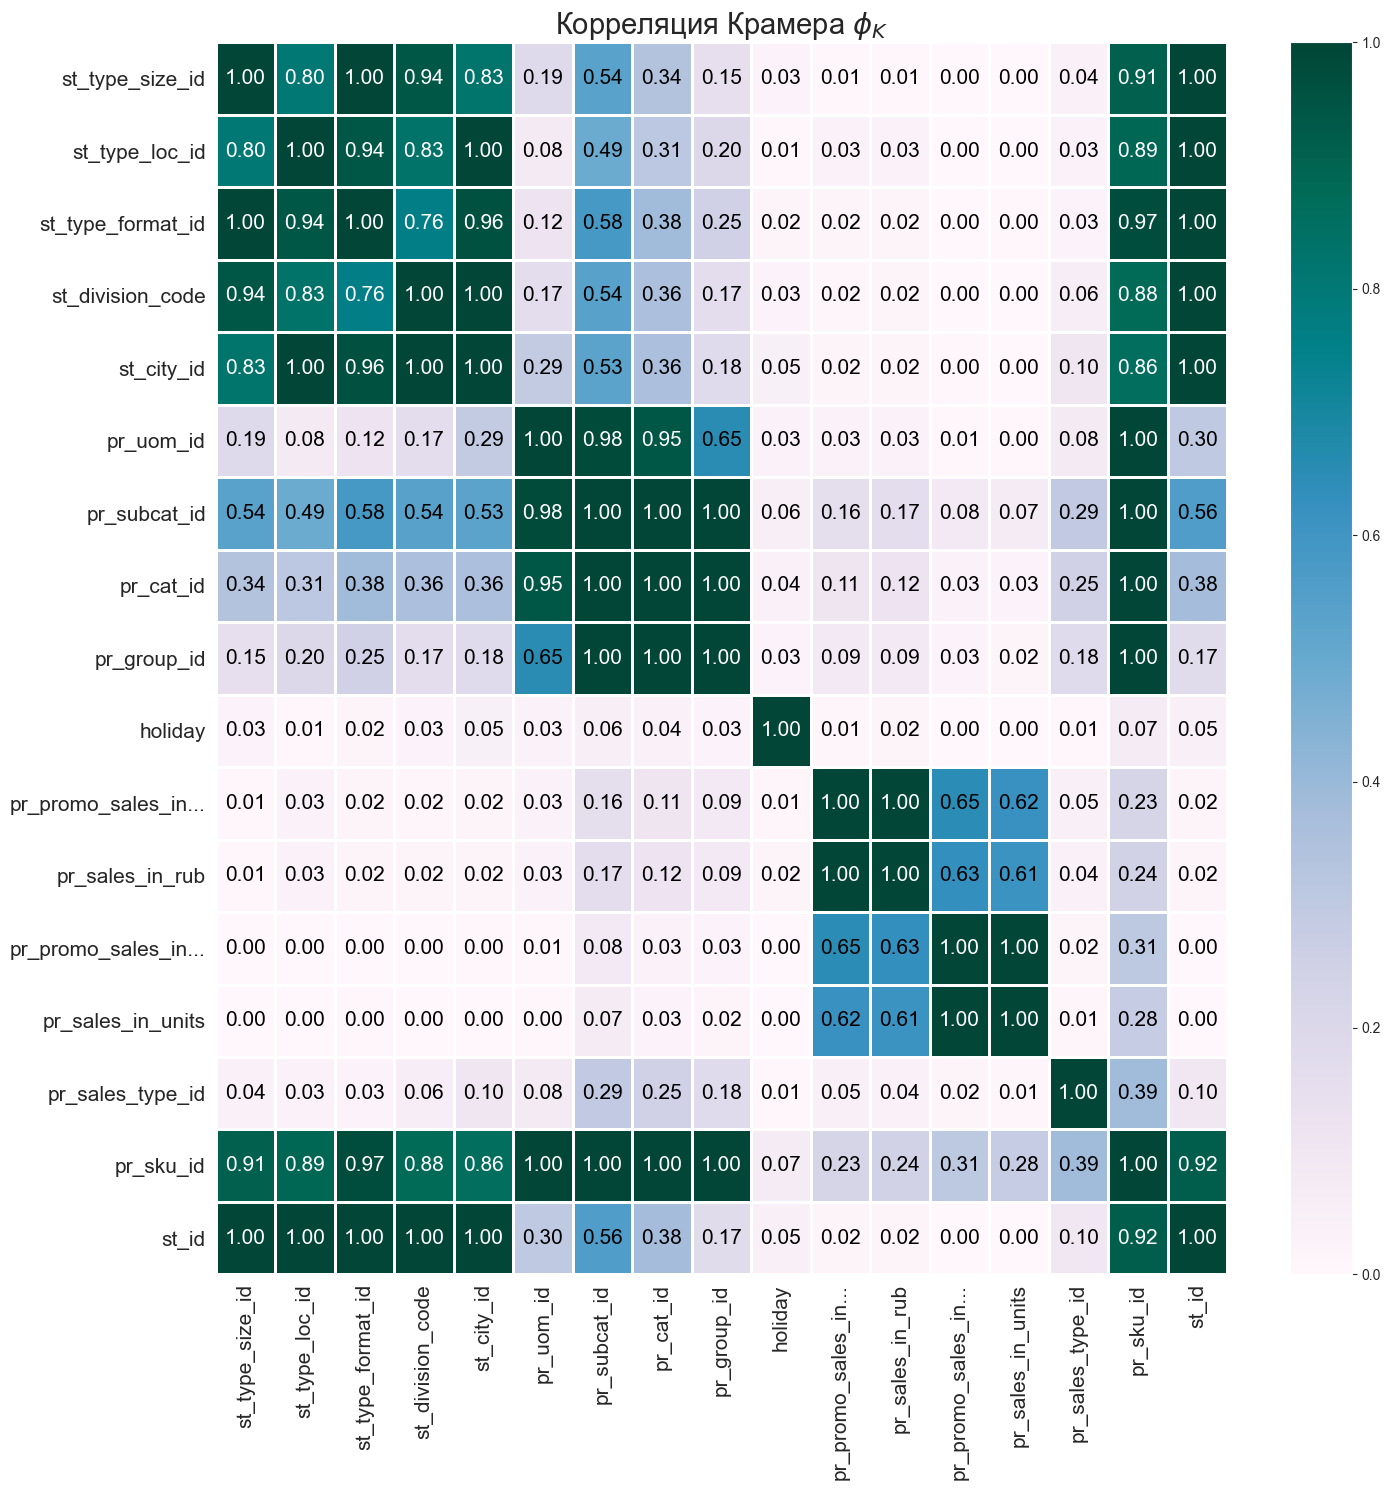

In [46]:
phik_matrix_plot(merged_df, ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub'])

- Целевой признак `pr_sales_in_units` (общие продажи) наиболее сильно коррелирует (значение 1.00) с  `pr_promo_sales_in_units` (продажи по промо) - это связано с тем, что первый включает в себя как продажи без промо,так и все продажи с промо. Также целевой признак сильно зависит (значения 0.57 и 0.58) от выручки (как общей, так и по промо). Менеее выраженная взаимосвязь целевого признака с `pr_sku_id` айди товара. Остальне признаки, судя по phi-k матрице, практически не оказывают влияния на спрос. 
- Данные по магазинам сильно взаимосвязаны друг с другом. Это логично - они сведены из одной таблицы, которая описывает информацию о торговых комплексах.
- Данне товарной иерархии тоже имеют всокую кореляцию друг с другом, поскольку также пришли из одной таблицы, которая детально описывает положение товара в иерархии. 
- Интересно, что праздники не показали влияние на другие признаки. Возможно,для анализа приздников и входных лучше взять временной ряд. 

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>

**ИДЕЯ ДЛЯ УЛУЧШЕНИЯ**

Подсчитать корреляцию между товарами. Не признаками, а именно товарами.
Выявить каннибализацию (когда проводим промо на оливье, страдают продажи салата столичный), выявить Гало эффект.  
Это позволяет найти "товары-соседи". К примеру если покупатель берёт _котлетку_, но высока вероятность что он возьмёт _макарошки_, а лучше _[пюрешку](https://youtu.be/A1Qb4zfurA8?si=LuFxfF8MO3FTZn5A)_.

### Обоснование выбора группы товаров для прототипа модели

Поскольку наши вычислительные мощности ограничены , как и сроки хакатона, то стоит сфокусироваться на получении рабочего решения. Для этого можем выбрать наиболее персективную группу товаров. 

#### Изучим топ-50 товаров по обьемам продаж, по выручке и по частоте продаж

In [47]:
# Создадим датафрейм, исключив строки с промо (pr_sales_type_id равным 1)
filtered_merged_df = merged_df[merged_df['pr_sales_type_id'] != 1]

# Удаляем столбцы промо из нового датафрейма
filtered_merged_df = filtered_merged_df.drop(['pr_promo_sales_in_rub',
                                              'pr_sales_type_id',
                                              'pr_promo_sales_in_units'], axis=1)

**Топ-50 товаров по суммарным обьемам продаж за весь период**  

In [48]:
# Группировка по pr_sku_id и суммирование продаж
product_sales_units = filtered_merged_df.groupby('pr_sku_id')['pr_sales_in_units'].sum().reset_index()

# Сортировка по количеству проданных товаров
top_50_units = product_sales_units.sort_values(by='pr_sales_in_units', ascending=False).head(50)

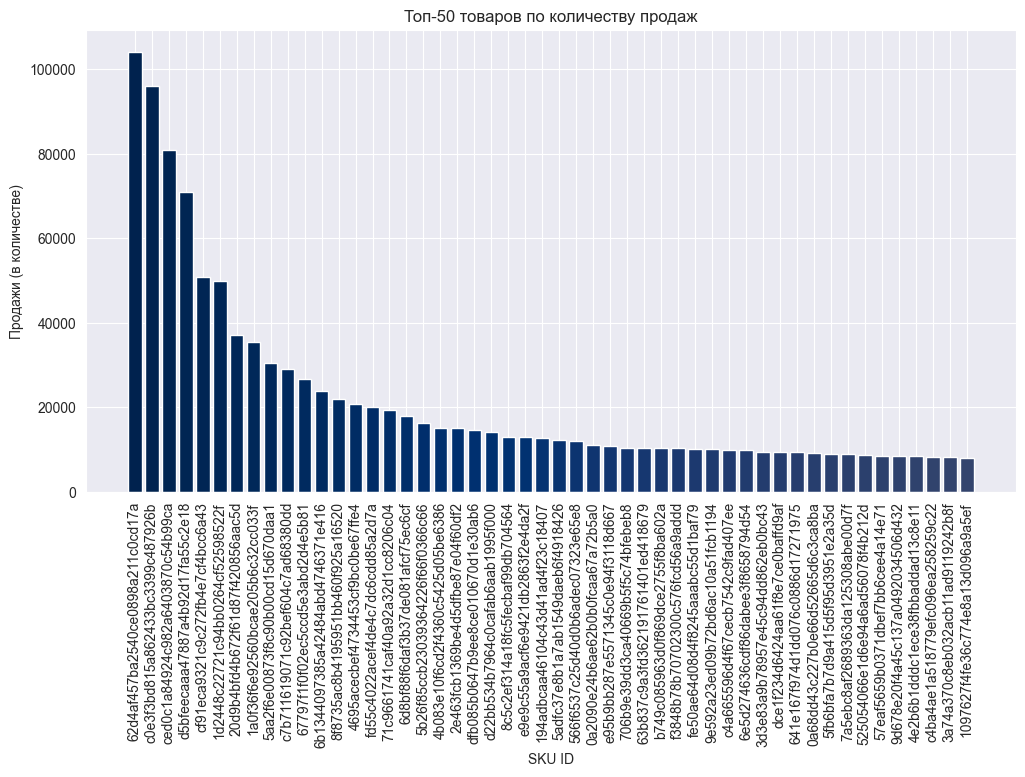

In [49]:
color_palette = plt.cm.cividis(range(len(top_50_units))) 

plt.figure(figsize=(12, 6))
plt.bar(top_50_units['pr_sku_id'], top_50_units['pr_sales_in_units'], color=color_palette)
plt.xlabel('SKU ID')
plt.ylabel('Продажи (в количестве)')
plt.title('Топ-50 товаров по количеству продаж')
plt.xticks(rotation=90)
plt.show()

In [50]:
# Создаем датафрейм с данными о топ-50 товарах
top_50_units_data = filtered_merged_df[filtered_merged_df['pr_sku_id'].isin(top_50_units['pr_sku_id'])]

**Топ-50 товаров по суммарной выручке за весь период** 

In [51]:
product_sales_rub = filtered_merged_df.groupby('pr_sku_id')['pr_sales_in_rub'].sum().reset_index()

# Сортировка по сумме продаж в рублях
top_50_rub = product_sales_rub.sort_values(by='pr_sales_in_rub', ascending=False).head(50)

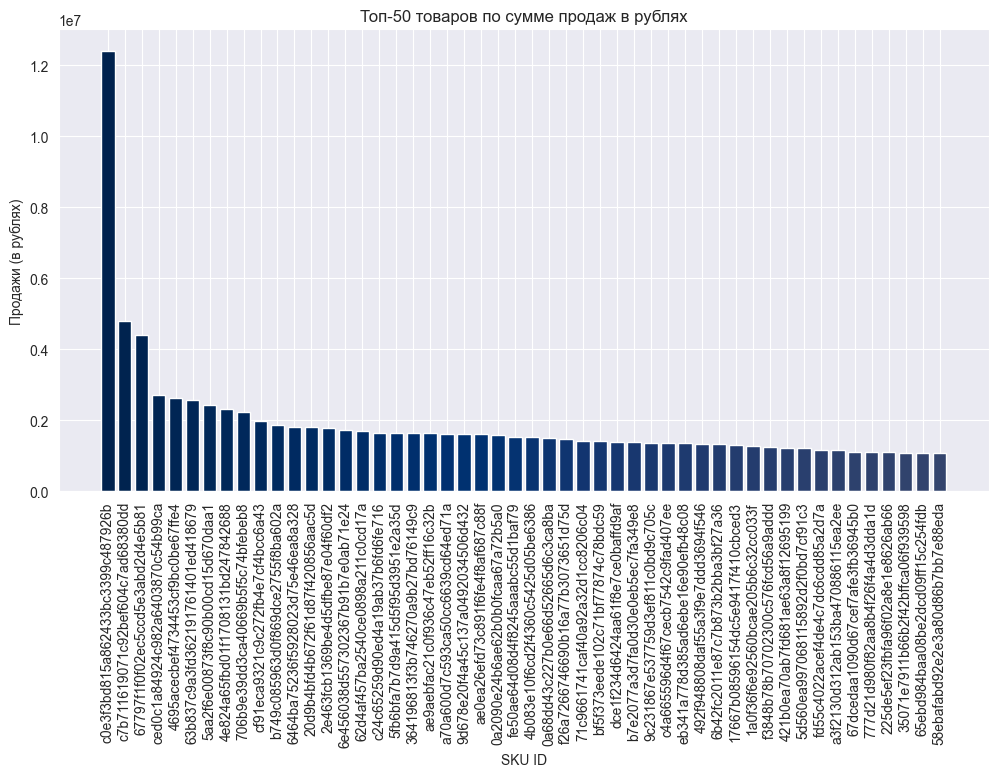

In [52]:
plt.figure(figsize=(12, 6))
plt.bar(top_50_rub['pr_sku_id'], top_50_rub['pr_sales_in_rub'], color=color_palette)
plt.xlabel('SKU ID')
plt.ylabel('Продажи (в рублях)')
plt.title('Топ-50 товаров по сумме продаж в рублях') 
plt.xticks(rotation=90)
plt.show()

In [53]:
# Создем датафрейм с данными о топ-50 товарах
top_50_rub_data = filtered_merged_df[filtered_merged_df['pr_sku_id'].isin(top_50_rub['pr_sku_id'])]

**Топ-50 товаров по частоте (количеству событий) продаж** 

In [54]:
# Получим количество строк для каждого pr_sku_id
sku_counts = filtered_merged_df['pr_sku_id'].value_counts()

# Выберем топ-50 товаров на основе максимального количества строк
top_50_max_rows = sku_counts.nlargest(50)

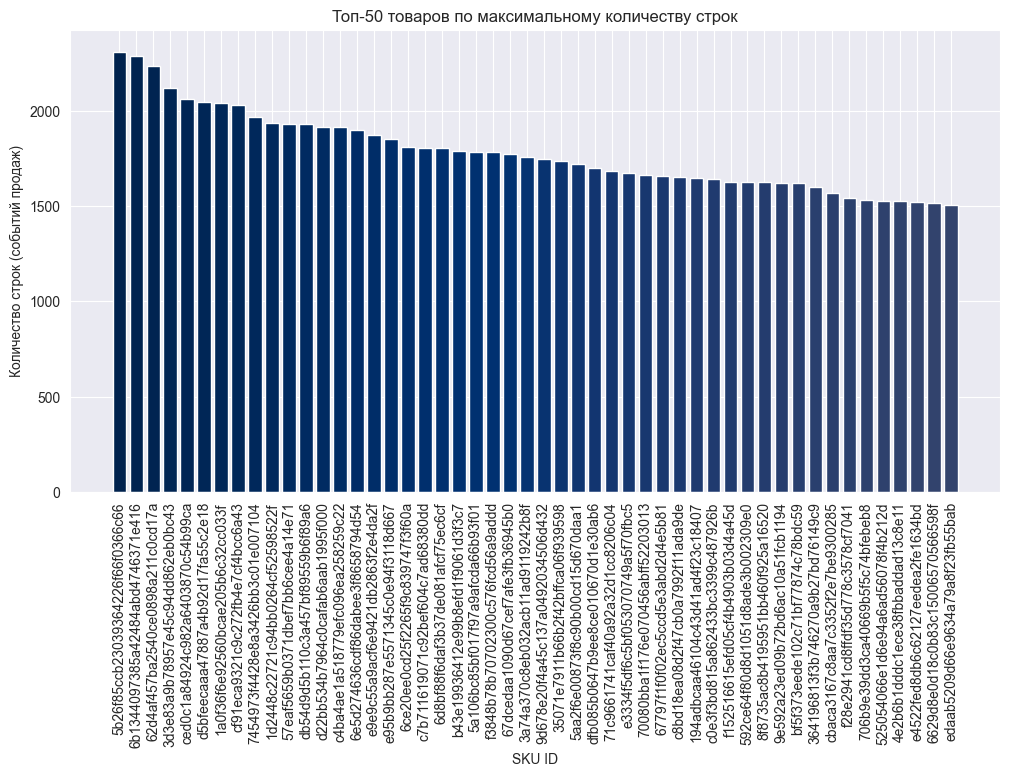

In [55]:
plt.figure(figsize=(12, 6))
plt.bar(top_50_max_rows.index, top_50_max_rows.values, color=color_palette)
plt.xlabel('SKU ID')
plt.ylabel('Количество строк (событий продаж)')
plt.title('Топ-50 товаров по максимальному количеству строк')
plt.xticks(rotation=90)
plt.show()

In [56]:
# Отоберем строки из исходного датафрейма, относящиеся к топ-50 товарам с максимальным количеством строк
top_50_max_rows_data = filtered_merged_df[filtered_merged_df['pr_sku_id'].isin(top_50_max_rows.index)]

**Сравним суммарную выручку за весь период по трем группам** 

- топ-50 товаров по количеству продаж, топ-50 товаров по суммарной выручке, топ-50 товаров по частоте продаж (количеству строк) 

In [57]:
total_revenue = filtered_merged_df['pr_sales_in_rub'].sum()
print('Суммарная выручка по всему датасету:', total_revenue, 'руб')

Суммарная выручка по всему датасету: 263599518.0 руб


In [58]:
top_50_units_revenue = top_50_units_data['pr_sales_in_rub'].sum()
print('Суммарная выручка по топ-50 товаров, отобранных по обьемам продаж:',
      top_50_units_revenue, 'руб')
print('Процент выручки топ-50 товаров, отобранных по обьемам продаж, от общей выручки:',
      round((top_50_units_revenue/total_revenue)*100, 1), '%')

Суммарная выручка по топ-50 товаров, отобранных по обьемам продаж: 73673800.0 руб
Процент выручки топ-50 товаров, отобранных по обьемам продаж, от общей выручки: 27.9 %


In [59]:
top_50_rub_revenue = top_50_rub_data['pr_sales_in_rub'].sum()
print('Суммарная выручка - топ-50 товаров, отобранных по обьемам выручки:',
      top_50_rub_revenue, 'руб')
print('Процент выручки топ-50 товаров, отобранных по обьемам выручки, от общей выручки:',
      round((top_50_rub_revenue/total_revenue)*100, 1), '%')

Суммарная выручка - топ-50 товаров, отобранных по обьемам выручки: 95756507.0 руб
Процент выручки топ-50 товаров, отобранных по обьемам выручки, от общей выручки: 36.3 %


In [60]:
top_50_max_rows_revenue = top_50_max_rows_data['pr_sales_in_rub'].sum()
print('Суммарная выручка по топ-50 товаров, отобранных по количеству фактических продаж:',
      top_50_max_rows_revenue, 'руб')
print('Доля выручки топ-50 товаров, отобранных по частоте продаж, от общей выручки:',
      round((top_50_max_rows_revenue/total_revenue)*100, 1), '%')

Суммарная выручка по топ-50 товаров, отобранных по количеству фактических продаж: 61861627.0 руб
Доля выручки топ-50 товаров, отобранных по частоте продаж, от общей выручки: 23.5 %


Наиболее привлекательно выглядит группа товаров, отобранных по обьемам выручки. Они составляют 36,3% от общей выручки. Но мы не видим маржу (не знаем разницу между выручкой и маржой, не знаем, одинаковй ли процент от себестоимости на все товары), потому сложно сказать, сколько прибли получит бизнес от тех или иных групп товаров. Также кажется довольно привлекательной группа топ-50 товаров, отобранных по обьемам продаж. Они составляют 27,9% от общей выручки. Меньше всего приносит группа товаров, отобранных по коичеству строк (событий) - 23.5 % от общей выручки.  

**Сравиним распределение товаров по признаку - штуки и граммы**

In [61]:
share_units = top_50_units_data['pr_uom_id'].value_counts()
print('топ-50 товаров, отобранных по объёмам продаж', share_units, '\n')

share_rub = top_50_rub_data['pr_uom_id'].value_counts()
print('топ-50 товаров, отобранных по объёмам выручки', share_rub, '\n')

share_rows = top_50_max_rows_data['pr_uom_id'].value_counts()
print('топ-50 товаров, отобранных по частоте продаж', share_rows) 

топ-50 товаров, отобранных по объёмам продаж pr_uom_id
17    48043
1     26383
Name: count, dtype: int64 

топ-50 товаров, отобранных по объёмам выручки pr_uom_id
1     49443
17    10347
Name: count, dtype: int64 

топ-50 товаров, отобранных по частоте продаж pr_uom_id
17    55153
1     33930
Name: count, dtype: int64


Данная проверка позволяет исключить ситуацию, при которой к нам в датасет попали только товары в граммах или только в штуках, что модет привести к дисбалансу и негативно отразиться на обучении модели. 

**Сравним размеры выборок топ-50 товаров** 

In [62]:
print('Размер выборки топ-50 по продажам', top_50_units_data.shape)
print('Размер выборки топ-50 по выручке', top_50_rub_data.shape)
print('Размер выборки топ-50 по частоте продаж', top_50_max_rows_data.shape)

Размер выборки топ-50 по продажам (74426, 15)
Размер выборки топ-50 по выручке (59790, 15)
Размер выборки топ-50 по частоте продаж (89083, 15)


Размеры групп товаров отличаются, но в целом число строк не настолько большое, чтобы это сказывалось на производительности алгоритмов. Потому модем работать с любой группой. 

**Выясним, сколько товаров попало во все три исследуеме группы** 

In [63]:
common_pr_sku_id = set(top_50_units_data['pr_sku_id']) & \
                   set(top_50_rub_data['pr_sku_id']) & \
                   set(top_50_max_rows_data['pr_sku_id'])

print('Количество товаров, попадающих во все три исследуемые группы:', len(common_pr_sku_id))

Количество товаров, попадающих во все три исследуемые группы: 12


Самой сомнительной выглядит группа топ-50 товаров, отобранных по количеству строк (частоте покупок), поскольку сложно обьяснить, какие факторы на это повлияли. Возможно, это какие-то сопутствующие товары, которе покупают в дополнение к остальным. Кросе того, у этой группы самая маленькая выручка из трех групп.

In [64]:
common_pr_sku_id_2 = set(top_50_units_data['pr_sku_id']) & set(top_50_rub_data['pr_sku_id'])

print('Количество товаров, попадающих в две исследуемые группы (отобранные по количеству продаж и выручке):',
      len(common_pr_sku_id_2))

Количество товаров, попадающих в две исследуемые группы (отобранные по количеству продаж и выручке): 25


In [65]:
common_pr_sku_id_3 = set(top_50_units_data['pr_sku_id']) & set(top_50_max_rows_data['pr_sku_id'])

print('Количество товаров, попадающих в две исследуемые группы (отобранные по количеству продаж и по часоте):',
      len(common_pr_sku_id_3))

Количество товаров, попадающих в две исследуемые группы (отобранные по количеству продаж и по часоте): 31


In [66]:
common_pr_sku_id_4 = set(top_50_rub_data['pr_sku_id']) & set(top_50_max_rows_data['pr_sku_id'])
                         
print('Количество товаров, попадающих в две исследуемые группы (отобранные по часоте продаж и по выручке):',
      len(common_pr_sku_id_4)) 

Количество товаров, попадающих в две исследуемые группы (отобранные по часоте продаж и по выручке): 16


- Исследуемые группы товаров имеют 12 пересекающихся товаров, следовательно группы не одинаковые. 
- 31 товар встречается в топ-50 товаров, отобранных по количеству продаж и по часоте. 
- 25 товаров встречается в топ-50 товаров, отобранных по количеству продаж (штук и грамм) и выручке.
- 16 товаров встречается в топ-50 товаров, отобранных по часоте продаж и по выручке.

**Вывод:** 

- Наиболее привлекательно выглядит группа товаров, отобранных по обьемам выручки. Они составляют 36,3% от общей выручки. Но мы не видим маржу (не знаем разницу между выручкой и маржой, не знаем, одинаковй ли процент от себестоимости на все товары), потому сложно сказать, сколько прибли получит бизнес от тех или иных групп товаров. Также кажется довольно привлекательной группа топ-50 товаров, отобранных по обьемам продаж. Они составляют 27,9% от общей выручки. Меньше всего приносит группа товаров, отобранных по коичеству строк (событий) - 23.5 % от общей выручки.  
- Размеры групп товаров отличаются, но в целом число строк не настолько большое, чтобы это сказывалось на производительности алгоритмов. Потому модем работать с любой группой. Данная проверка позволяет исключить ситуацию, при которой к нам в датасет попали только товары в граммах или только в штуках, что модет привести к дисбалансу и негативно отразиться на обучении модели.
- Исследуемые группы товаров имеют 12 пересекающихся товаров, следовательно грунны не одинаковые. 31 товар встречается в топ-50 товаров, отобранных по количеству продаж и по часоте. 25 товаров встречается в топ-50 товаров, отобранных по количеству продаж (штук и грамм) и выручке. 16 товаров встречается в топ-50 товаров, отобранных по часоте продаж и по выручке.

**Поскольку для бизнеса деньги яляются одной из ключевых метрик (помимо, например, расширения клиентской базы), выбор сделаю на группе топ-50 товаров, которые приносят самую большую выручку.** 

### Временные ряды

Построим графики временных рядов по всем товарам и признакам, чтобы посмотреть общую тенденцию.

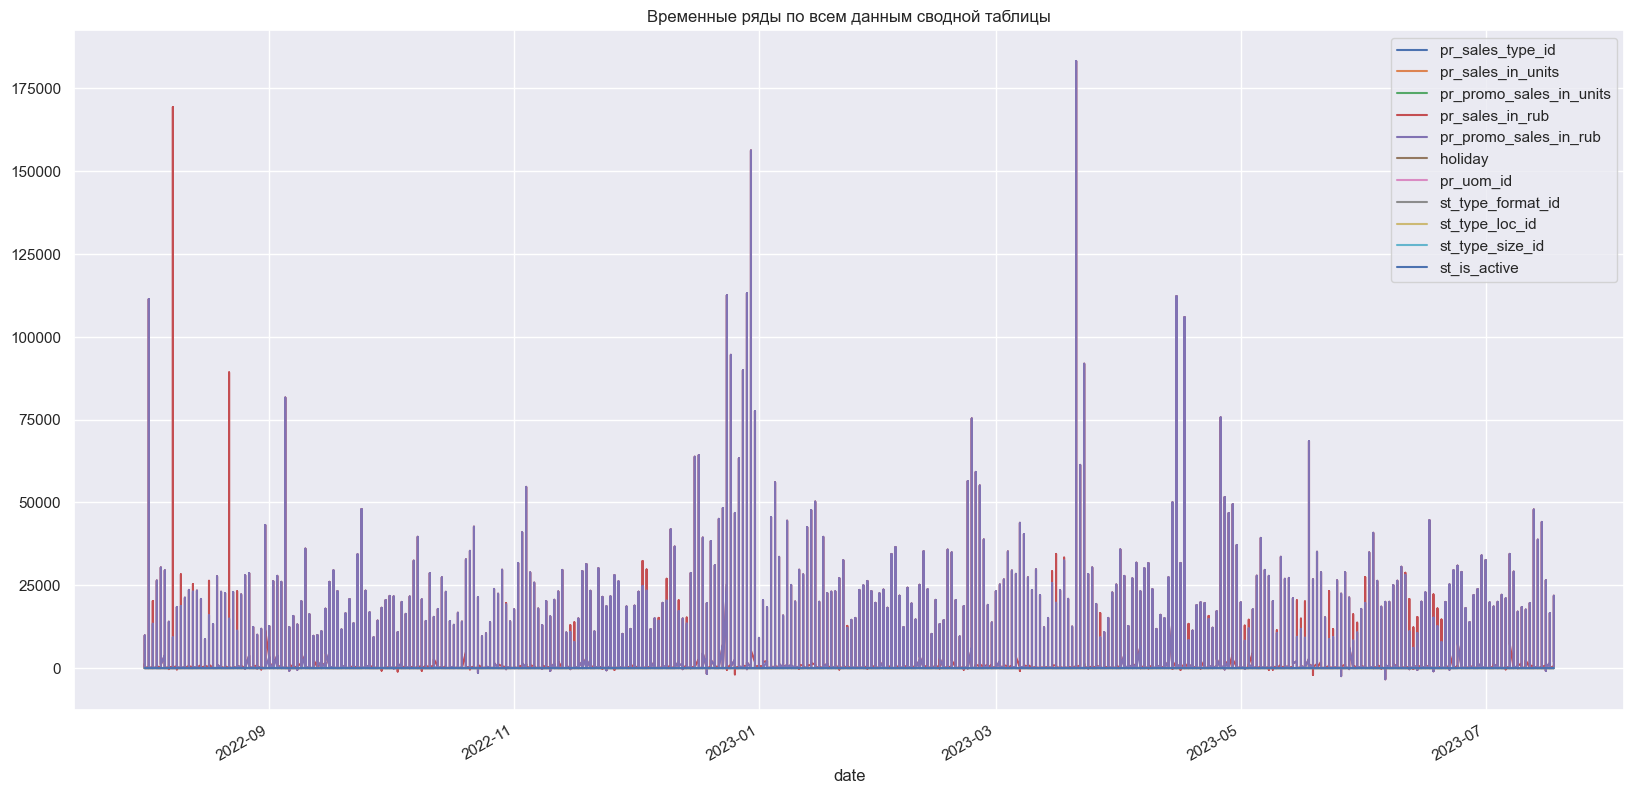

In [67]:
custom_palette = sns.color_palette("husl", n_colors=len(merged_df.columns))

sns.set_palette(custom_palette)
sns.set(style="darkgrid")

merged_df.plot(figsize=(20, 10))
plt.title("Временные ряды по всем данным сводной таблицы")
plt.show()
None

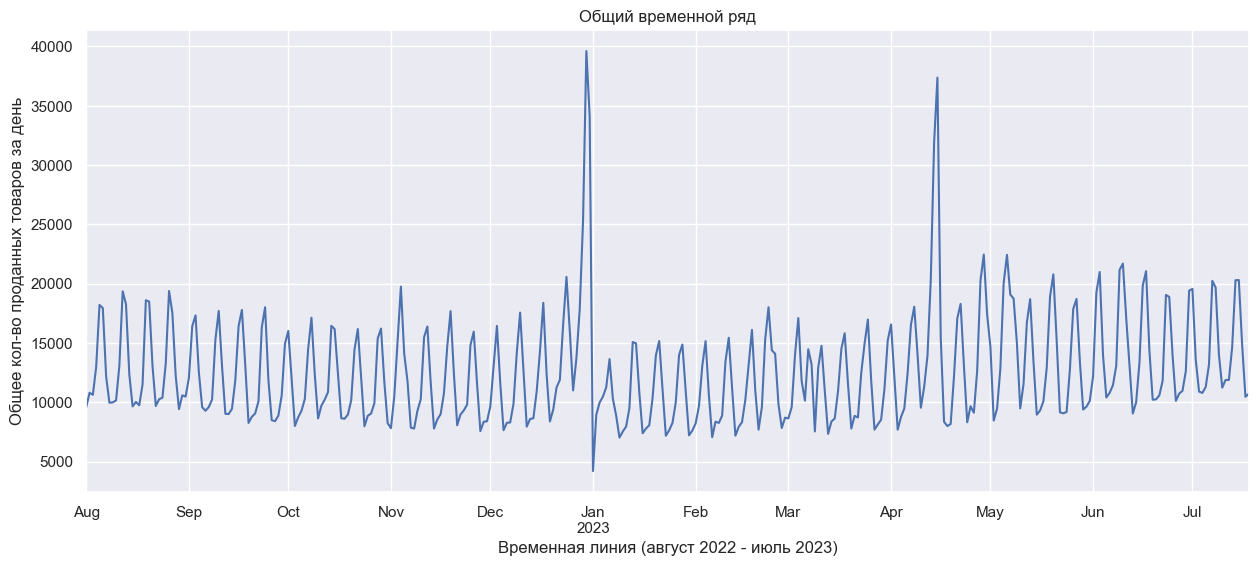

In [68]:
# Общий временной ряд
sales_df.groupby('date')['pr_sales_in_units'].sum().plot(
    title='Общий временной ряд',
    xlabel='Временная линия (август 2022 - июль 2023)',
    ylabel='Общее кол-во проданных товаров за день',
    figsize=FIGSIZE,
    grid=True);

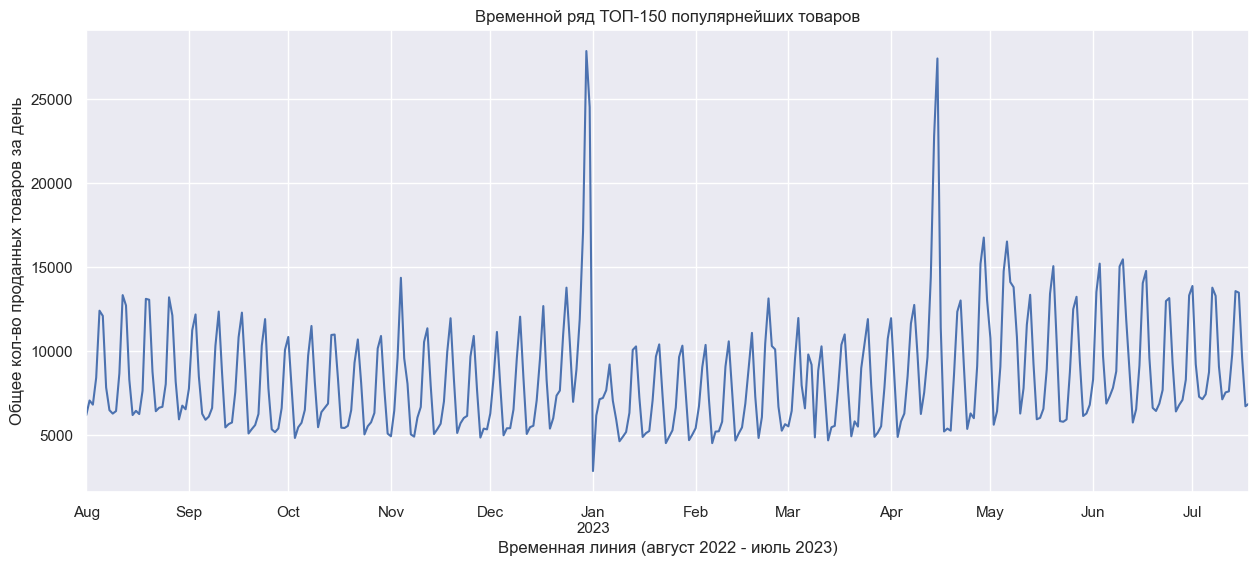

In [69]:
# малый временной ряд
group_sales[group_sales['pr_sku_id'].isin(top_150_sku_by_units)].groupby('date')['pr_sales_in_units'].sum().plot(
    title='Временной ряд ТОП-150 популярнейших товаров',
    xlabel='Временная линия (август 2022 - июль 2023)',
    ylabel='Общее кол-во проданных товаров за день',
    figsize=FIGSIZE,
    grid=True);

Временной ряд ТОП-150 популярнейших товаров внешне повторяет общий ряд всех продуктов. Это может говорить, что искуственное ограничение на 150 товарах не должно отразиться негативно. При первичном осмотре можно сказать, что сезоности и пиковые дни сохранились. На меньшей выборке можно проводить полноценный анализ, выводы из которого будут справедливы и для генеральной выборки.

**Промежуточный вывод:**

Продажи в закрытых магазинах составляет меньше 0.1% от общего числа, и собраны за короткий период: 1 авг - 8 сен 2022 года. Из 2050 наименований продавалось лишь 1991 товар. Все записи о продаже предоставлены только из "известных" магазинов, информация о которых есть в сводной таблице о магазинах.

Данные об общем кол-ве продаж содержит _крайне большие_ значения, а так же _отрицательные_ значения. Установлены границы. Нормальными будут считаться значения в диапазоне [0; 17.5], где 17.5 = Q3 + std (3-й квантиля + стандартного отклонения). Выбросами и аномалиями будут признаны ~5% данных.

Обнаружены:
- _убыточные операции_ (факт возврата - отсутствует, но есть уход денежных средств) - 8 объектов,
- _неучтённые операции_ (факт продажи - отсутствует, но есть поступление денежных средств) - 66 000 объектов (7.5% от общего числа).

Убыточные операции похожи на кражу товара и вычет его стоимости из "кассы". Небольшое количество таких объектов позволяет их удалить. Неучтённых операций, наоборот, очень много и прежде чем принять решение об их удалении необходим более подробный анализ. Возможно это неучтённая сумма, оставшаяся с прошлого дня.

___

## Исследовать признаки (EDA)

Посчитать цены:
- Стоимость одного товара (за день)
- Стоимость группы товаров (за день)

(День — Товар — Магазин — Продажа в штуках — Продажа в рублях — доля продаж по ПРОМО)

In [70]:
# итоговый набор данных
popular_sales = group_sales[group_sales['pr_sku_id'].isin(top_150_sku_by_units)]
display(popular_sales)

,st_id,pr_sku_id,date,pr_sales_in_units,pr_sales_in_rub,price,promo_price
36,084a8a9aa8cced9175bd07bc44998e75,c4a665596d4f67cecb7542c9fad407ee,2023-05-01,2.0,287.0,143.500000,NaN
37,084a8a9aa8cced9175bd07bc44998e75,c4a665596d4f67cecb7542c9fad407ee,2023-05-06,3.0,405.0,NaN,135.000000
344,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2022-08-01,6.0,1095.0,178.000000,191.500000
345,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2022-08-02,8.0,1578.0,195.500000,202.500000
346,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2022-08-03,3.0,662.0,220.666667,NaN
...,...,...,...,...,...,...,...
660607,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fe50ae64d08d4f8245aaabc55d1baf79,2023-07-14,9.0,1177.0,NaN,130.777778
660608,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fe50ae64d08d4f8245aaabc55d1baf79,2023-07-15,6.0,884.0,NaN,147.333333
660609,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fe50ae64d08d4f8245aaabc55d1baf79,2023-07-16,12.0,1674.0,NaN,139.500000
660610,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fe50ae64d08d4f8245aaabc55d1baf79,2023-07-17,7.0,911.0,NaN,130.142857


In [71]:
# статистическая информация по магазинам (количество и объём продаж)
popular_sales.groupby('st_id')[['pr_sales_in_units', 'pr_sales_in_rub']].agg(
    ['count','min', 'median', 'mean', 'max', 'sum'])

pr_sales_in_units                          \
                                             count   min median       mean   
st_id                                                                        
084a8a9aa8cced9175bd07bc44998e75                 2   2.0    2.5   2.500000   
16a5cdae362b8d27a1d8f8c7b78b4330             40361  -4.0    8.0  15.739575   
1ecfb463472ec9115b10c292ef8bc986              6265   1.0    5.0   6.389306   
42a0e188f5033bc65bf8d78622277c4e             38896 -39.0    6.0  13.305610   
53e19f3dbb211f20b20b45668303c1b6               865   1.0    4.0   4.452023   
6364d3f0f495b6ab9dcf8d3b5c6e0b01             36623  -6.0    5.0  10.500341   
bd470ca955d9497bbcb808e59952fffc               259   1.0    4.0   4.725869   
c81e728d9d4c2f636f067f89cc14862c             37330  -3.0    9.0  15.329012   
f7e6c85504ce6e82442c770f7c8606f0             35355  -3.0    6.0  12.735030   
fa7cdfad1a5aaf8370ebeda47a1ff1c3             35095   1.0    5.0  11.204559   

                                                   pr_sales_in_rub          \
                                     max       sum           count     min   
st_id                                                                        
084a8a9aa8cced9175bd07bc44998e75     3.0       5.0               2   287.0   
16a5cdae362b8d27a1d8f8c7b78b4330  1271.0  635265.0           40361  -845.0   
1ecfb463472ec9115b10c292ef8bc986   127.0   40029.0            6265     8.0   
42a0e188f5033bc65bf8d78622277c4e  1236.0  517535.0           38896 -1741.0   
53e19f3dbb211f20b20b45668303c1b6    26.0    3851.0             865     1.0   
6364d3f0f495b6ab9dcf8d3b5c6e0b01  1596.0  384554.0           36623  -240.0   
bd470ca955d9497bbcb808e59952fffc    19.0    1224.0             259    24.0   
c81e728d9d4c2f636f067f89cc14862c   917.0  572232.0           37330  -842.0   
f7e6c85504ce6e82442c770f7c8606f0   959.0  450247.0           35355  -221.0   
fa7cdfad1a5aaf8370ebeda47a1ff1c3  2362.0  393224.0           35095     3.0   

                                                                            
                                 median         mean       max         sum  
st_id                                                                       
084a8a9aa8cced9175bd07bc44998e75  346.0   346.000000     405.0       692.0  
16a5cdae362b8d27a1d8f8c7b78b4330  734.0  1807.668442  156241.0  72959306.0  
1ecfb463472ec9115b10c292ef8bc986  217.0   304.608140    5678.0   1908370.0  
42a0e188f5033bc65bf8d78622277c4e  580.0  1432.403229  183265.0  55714756.0  
53e19f3dbb211f20b20b45668303c1b6  159.0   189.302890    1241.0    163747.0  
6364d3f0f495b6ab9dcf8d3b5c6e0b01  454.0  1120.368594   96692.0  41031259.0  
bd470ca955d9497bbcb808e59952fffc  173.0   186.011583     651.0     48177.0  
c81e728d9d4c2f636f067f89cc14862c  669.0  1387.560889   66525.0  51797648.0  
f7e6c85504ce6e82442c770f7c8606f0  565.0  1285.660812   75333.0  45454538.0  
fa7cdfad1a5aaf8370ebeda47a1ff1c3  537.0  1216.560137   62863.0  42695178.0

In [72]:
# анализ непопулярного магазина
st_id = '084a8a9aa8cced9175bd07bc44998e75'

object_count = sales_df[sales_df['st_id'] == st_id].shape[0]
since = sales_df.loc[sales_df['st_id'] == st_id, 'date'].min().date()
to = sales_df.loc[sales_df['st_id'] == st_id, 'date'].max().date()

print('Кол-во совершенных продаж: {} ({:.3%})'.format(object_count, object_count/sales_df.shape[0]))
print('Временной период: от {} до {} ({} дней)'.format(since, to, (to-since).days+1))

Кол-во совершенных продаж: 38 (0.005%)
Временной период: от 2023-03-26 до 2023-06-29 (96 дней)


Для всех 10 активных магазинов, разрабатываемая предсказательная модель будет очень полезна, поскольку в каждом из них товары продаются зачастую сотнями тысячами за год. За исключением `53e19f3dbb211f20b20b45668303c1b6` и `bd470ca955d9497bbcb808e59952fffc`. И особенно `084a8a9aa8cced9175bd07bc44998e75`.

In [73]:
# статистическая информация по товарам (количество и объём продаж)
sku_distribution = popular_sales.groupby('pr_sku_id').agg({'pr_sales_in_units':['count', 'median', 'mean', 'max', 'sum'],
                                                           'pr_sales_in_rub':['min', 'median', 'mean', 'max', 'sum'],
                                                           'price':['mean'],
                                                           'promo_price':['mean']})

sku_distribution['mean_discount'] = (1 - sku_distribution['promo_price'] / sku_distribution['price'])

display(sku_distribution)

pr_sales_in_units                           \
                                             count median       mean    max   
pr_sku_id                                                                     
0094042bfeae507dc7f62acc8e5ed03a              1610    5.0   7.896273   82.0   
050a8120e2a3b8751df8752fcc0323ef              1086    7.0  12.186004  107.0   
06076bf3c802444ebc7d5619ab64ceb6               753    8.0  12.289509  113.0   
0a2090e24b6ae62b0b0fcaa67a72b5a0              1599    9.0  21.744841  529.0   
0a68dd43c227b0e66d52665d6c3ca8ba              1797   16.0  29.015025  251.0   
...                                            ...    ...        ...    ...   
f152516615efd05cf4b4903b03d4a45d              2003    4.0   4.795307   32.0   
f26a7266746690b16a77b3073651d75d              1921    4.0   4.632483   61.0   
f3848b78b70702300c576fcd56a9addd              2065    5.0   6.886683   54.0   
fd55c4022acef4de4c7dc6cdd85a2d7a               273   99.0  99.479853  216.0   
fe50ae64d08d4f8245aaabc55d1baf79              2106    9.0  10.119183   88.0   

                                          pr_sales_in_rub          \
                                      sum             min  median   
pr_sku_id                                                           
0094042bfeae507dc7f62acc8e5ed03a  12713.0            33.0   818.0   
050a8120e2a3b8751df8752fcc0323ef  13234.0            74.0  1074.0   
06076bf3c802444ebc7d5619ab64ceb6   9254.0           560.0  3355.0   
0a2090e24b6ae62b0b0fcaa67a72b5a0  34770.0            55.0  1280.0   
0a68dd43c227b0e66d52665d6c3ca8ba  52140.0            93.0  2259.0   
...                                   ...             ...     ...   
f152516615efd05cf4b4903b03d4a45d   9605.0            56.0   503.0   
f26a7266746690b16a77b3073651d75d   8899.0           104.0   963.0   
f3848b78b70702300c576fcd56a9addd  14221.0            54.0   621.0   
fd55c4022acef4de4c7dc6cdd85a2d7a  27158.0            49.0  5520.0   
fe50ae64d08d4f8245aaabc55d1baf79  21311.0            80.0  1229.0   

                                                                        price  \
                                         mean      max        sum        mean   
pr_sku_id                                                                       
0094042bfeae507dc7f62acc8e5ed03a  1352.002484  13404.0  2176724.0  193.890874   
050a8120e2a3b8751df8752fcc0323ef  1913.164825  14084.0  2077697.0  182.066594   
06076bf3c802444ebc7d5619ab64ceb6  4811.610890  41774.0  3623143.0  467.454926   
0a2090e24b6ae62b0b0fcaa67a72b5a0  2693.064415  66525.0  4306210.0  146.374379   
0a68dd43c227b0e66d52665d6c3ca8ba  3871.871452  30347.0  6957753.0  162.292956   
...                                       ...      ...        ...         ...   
f152516615efd05cf4b4903b03d4a45d   627.062906   4423.0  1256007.0  135.905224   
f26a7266746690b16a77b3073651d75d  1204.478397  15981.0  2313803.0  281.387336   
f3848b78b70702300c576fcd56a9addd   802.527361   6605.0  1657219.0  121.607158   
fd55c4022acef4de4c7dc6cdd85a2d7a  5665.820513  12623.0  1546769.0   58.567916   
fe50ae64d08d4f8245aaabc55d1baf79  1416.906458  13502.0  2984005.0  150.714357   

                                 promo_price mean_discount  
                                        mean                
pr_sku_id                                                   
0094042bfeae507dc7f62acc8e5ed03a  162.790274      0.160403  
050a8120e2a3b8751df8752fcc0323ef  148.930770      0.181998  
06076bf3c802444ebc7d5619ab64ceb6  395.357782      0.154233  
0a2090e24b6ae62b0b0fcaa67a72b5a0  123.565349      0.155827  
0a68dd43c227b0e66d52665d6c3ca8ba  131.554601      0.189400  
...                                      ...           ...  
f152516615efd05cf4b4903b03d4a45d  116.812084      0.140489  
f26a7266746690b16a77b3073651d75d  230.781055      0.179846  
f3848b78b70702300c576fcd56a9addd  102.304417      0.158730  
fd55c4022acef4de4c7dc6cdd85a2d7a   53.447090      0.087434  
fe50ae64d08d4f8245aaabc55d1baf7

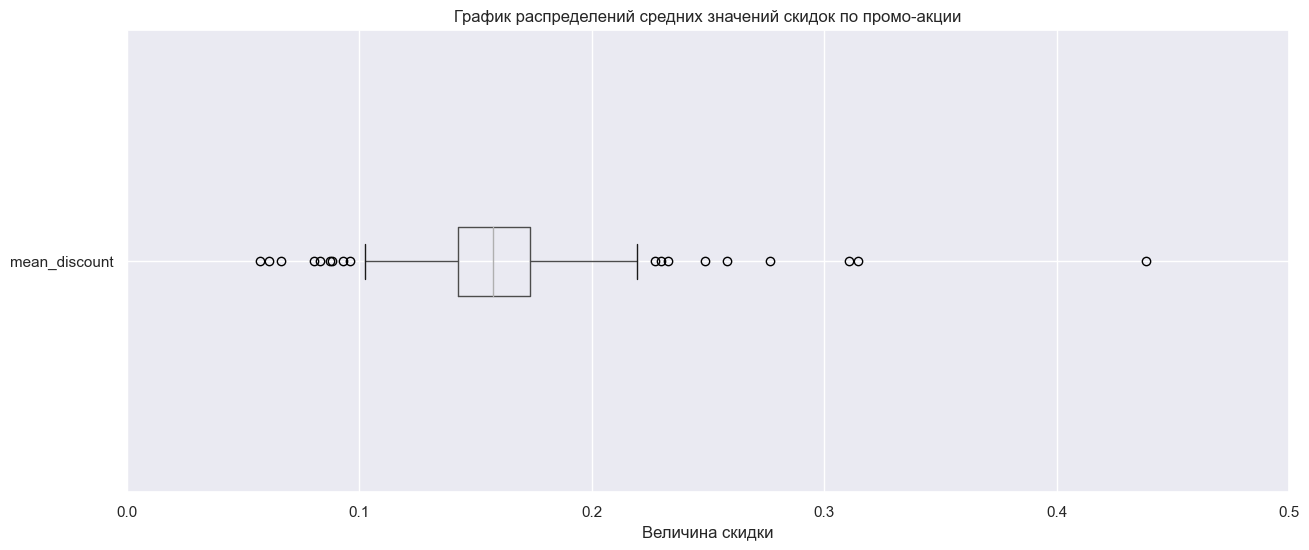

In [74]:
plt.figure(figsize=FIGSIZE)
sku_distribution.boxplot('mean_discount', vert=False)
plt.title('График распределений средних значений скидок по промо-акции')
plt.xlabel('Величина скидки')
plt.xlim(0.0, 0.5)
plt.grid(True)
plt.show()

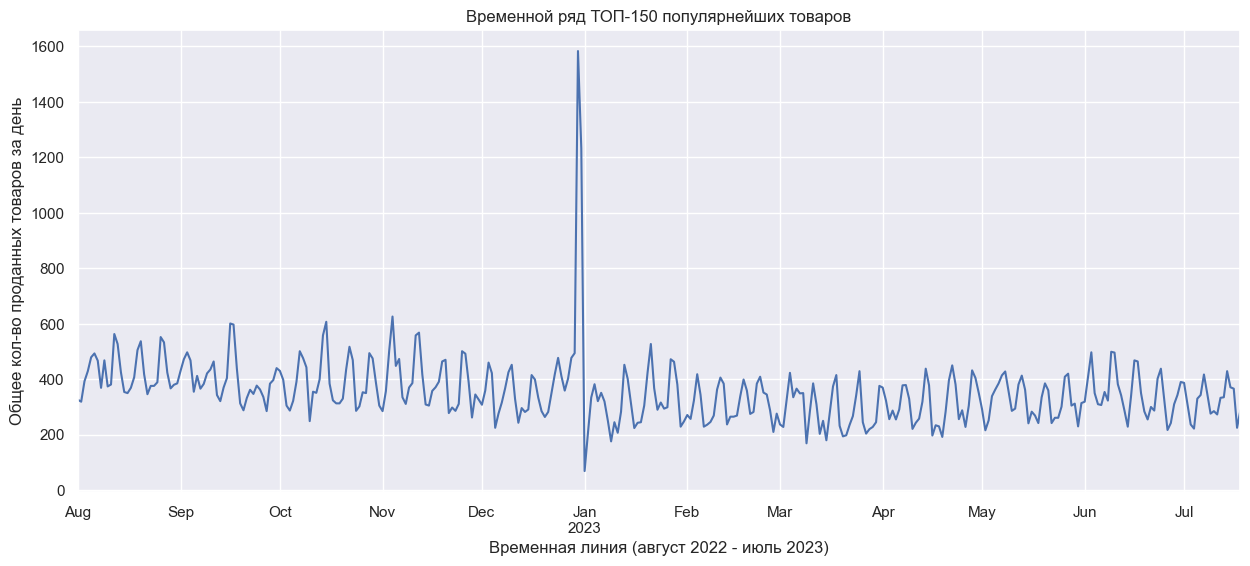

In [75]:
# временной ряд товара №0
group_sales[group_sales['pr_sku_id'] == top_150_sku_by_units[0]].groupby('date')['pr_sales_in_units'].sum().plot(
    title='Временной ряд ТОП-150 популярнейших товаров',
    xlabel='Временная линия (август 2022 - июль 2023)',
    ylabel='Общее кол-во проданных товаров за день',
    figsize=FIGSIZE,
    grid=True);



___

# Вывод 

Продажи в закрытых магазинах составляет меньше 0.1% от общего числа, и собраны за короткий период: 1 авг - 8 сен 2022 года. Из 2050 наименований продавалось лишь 1991 товар. Все записи о продаже предоставлены только из "известных" магазинов, информация о которых есть в сводной таблице о магазинах.

Данные об общем кол-ве продаж содержит _крайне большие_ значения, а так же _отрицательные_ значения. Установлены границы. Отрицательные и нулевые значения признаны аномальными и удалены из датасета (~5% данных). Выбросы оставлены, не смотря на их большие значения.

Обнаружены:
- _убыточные операции_ (факт возврата - отсутствует, но есть уход денежных средств) - 8 объектов,
- _неучтённые операции_ (факт продажи - отсутствует, но есть поступление денежных средств) - 66 000 объектов (7.5% от общего числа),
- _убытки_  (факт продажи присутствует, но поступление денежных средств нет) - около 790 объектов,
- _абсолютный ноль_ (никаких продаж, никаких денежных поступлений) - около 450 объектов.

Убыточные операции похожи на кражу товара и вычет его стоимости из "кассы". Небольшое количество таких объектов позволяет их удалить. Неучтённых операций, наоборот, очень много и прежде чем принять решение об их удалении необходим более подробный анализ. Возможно это неучтённая сумма, оставшаяся с прошлого дня.  Общий объём аномальны данных - около 8%. 

Около 40% записей являются неявными дубликатами. Создан новый датасет `group_sales`, котором объединены дублирующий продажи (без промо-акции и с ними). Подробный анализ и аргументация приведена в разделе "Неявные дубликаты". Далее этот датасет будет использоваться как основной.

Обзор временных рядов выявило наличие недельной сезонности, и пиковых продаж в несколько праздничных дней. Среди них особе выделился новый год и середина апреля. Выбросы (крайне высокие продажи) - были оставлены. Нулевые и отрицательные продажи - удалены.

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>

**ПЛАН ДЛЯ ДОРАБОТКИ** 

- Рассчитать среднюю цену на товары (стоимость за единицу товара) и прогнозировать ее с помощью Prophet или Arima в качестве первой ступени прогноза. Это позволит получить дополнительный признак, который модно подавать на вход модели. 
- Построить алгорим для прогноза бОльшего числа пар товар-магазин, чтобы повысить общую точность прогнозирования и охватить больше товаров
- Применить кластеризацию для определения похожих пар товар-магазин, а затем строить модели по группам, а не по отдельным товарам. Это позволит сэкономить вычислительняе и временнЫе ресурсы. Оптимальный вариант, чтобы охватить бОльшее количество товаров, но не уронить качество.

___